In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Setting
An agent can be one of three types: $\theta_L = 0, \theta_M= 1$ or $\theta_H= 2$. They choose an effort level $e\in \{1, 2, 3\}$ and produce an output $y=A+B[(\theta + e)\omega - \frac{e^2}{2}]$ where $\omega$ is an exogenous parameter that can take the values $\omega_L = 1, \omega_M = 2$ or $\omega_H =3$ each with $1/3$ probability. I call $\omega$ the exchange rate. A and B are non-negative parameters.

Instead of observing the output y, the agent observes only a success or a failure. The probability that they get a success is given by $p[success|\theta, \omega, e]=\frac{y}{K+y}$ where $K$ is a non-negative constant.
A, B and K must be chosen to satisfy some conditions: y is non-negative, p and (1-p) are log-submodular ($p_{\theta, \omega}p\leq p_\theta p\omega$ and $p_{\theta, \omega}(1-p)\leq p_\theta p_\omega$). And I also need to generate probabilities of success that are distinct enough across types and exchange rates.


In [2]:
# three possible values for the agent's type
Theta_L = 0
Theta_M = .3
Theta_H = .5
# three possible values for the exogenous parameter
w_l = 1
w_m = 3
w_h = 5

w = [w_l, w_m, w_h]

# the possible effort choices have to correspond to the possible exchange rates w because those values max output
effort = w

# Three extra parameters for the output function and the probability transformation
A = 2
B = 1/4
K = 1
param = [A, B, K]

#the prior is uniform over omega
pi_0 = [1/3, 1/3, 1/3]

A function that generates the output as in Heidhues, Koszegi and Strack and transforms it into a probability of success. The transformation ensures that all the important properties are preserved. The probability should be log-submodular as in Hestermann and Le Yaouanq.

In [3]:
def p(pars, e, o, w):
    out = pars[0]+pars[1]*((o+e)*w-(e**2)/2)
    prob_s = out/(out+pars[2])
    return prob_s

With the function $p$ I can generate the probability of success for all possible combinations of $(\theta, \omega, e)$. Each matrix represents a type $\theta$, each column represents an exchang rate in ascending order and the rows are effort also in ascending order 

In [4]:
# calculate the true probability matrices
Mat_L = []
Mat_M = []
Mat_H = []

for e in effort:
    Mat_L.append([p(param, e, Theta_L, w[0]), p(param, e, Theta_L, w[1]), p(param, e, Theta_L, w[2])])
    Mat_M.append([p(param, e, Theta_M, w[0]), p(param, e, Theta_M, w[1]), p(param, e, Theta_M, w[2])])
    Mat_H.append([p(param, e, Theta_H, w[0]), p(param, e, Theta_H, w[1]), p(param, e, Theta_H, w[2])])

Mat_L = np.array(Mat_L)
Mat_M = np.array(Mat_M)
Mat_H = np.array(Mat_H)

M0 = [Mat_L, Mat_M, Mat_H]

print('low theta')
print(Mat_L)
print('medium theta')
print(Mat_M)
print('high theta')
print(Mat_H)

low theta
[[0.68       0.72413793 0.75757576]
 [0.61904762 0.75757576 0.82222222]
 [0.11111111 0.72413793 0.83673469]]
medium theta
[[0.6875     0.74025974 0.77777778]
 [0.62962963 0.77011494 0.83333333]
 [0.16666667 0.74025974 0.84615385]]
high theta
[[0.69230769 0.75       0.78947368]
 [0.63636364 0.77777778 0.84      ]
 [0.2        0.75       0.85185185]]


Here are matrices that are not computed with the formula above. I modified the values to get larger differences from one choice to another without altering the way in which the values are ordered. I did it so that the lowest value is 0% and the largest is 90%. While having at least a 5% point jump between elements of the same matrix.

In [5]:
ML = np.array([[.30, .40, .55], [.20, .55, .65], [0, .40, .75]])
MM = np.array([[.35, .45, .60], [.25, .60, .70], [.05, .45, .80]])
MH = np.array([[.40, .50, .65], [.30, .65, .80], [.10, .50, .95]])



I will define the output function separately just in case we need it later.

In [6]:
def y(pars, e, o, w):
    out = pars[0]+pars[1]*((o+e)*w-(e**2)/2)
    return out
    

With the matrices now I can compute the expected utility for each of the effort levels. This way I know which effort each agent would choose depending on the type that they believe that they are. (I will start with a type with a degenerate belief and then extend to the bayesian with self serving attribution later on)

In [7]:
# a function that computes the expected probability of success under each effort choice
# given the belief about the omegas. The expected value muyt be computed separately for each type.
def Eu(prior, type_belief, M):
    # type belief should be 0, 1, or 2
    # the prior is over omegas. 
    # M is a vector of the three probability matrices (L, M, H)
    Eu = np.dot(M[type_belief], prior)
    return Eu

For whatever theta the agent thinks that is their type, they will choose the effort level that maximizes their payoff given their prior. The next function finds the index of the effort level that thy will choose. It takes as an argument the vector of expected utilities for the believed type.

In [8]:
# a function that finds the effort level given the prior over omega
def choice(Eu_believed):
    e_index = np.argmax(Eu_believed)
    return e_index

In [9]:
# a function for the bayes update on omega
def bayesW(p0, e_index, o, M, believed_type):
    matrix = M[believed_type]
    row = matrix[e_index, :]
    if o == 1:
        p1 = np.diag(np.diagflat(p0)@np.diagflat(row))/np.sum(np.diag(np.diagflat(p0)@np.diagflat(row)))
    else:
        p1 = np.diag(np.diagflat(p0)@np.diagflat(1-row))/np.sum(np.diag(np.diagflat(p0)@np.diagflat(1-row)))
        
    return p1

In [10]:
# a function that updates omega and theta with a self serving attribution bias
def ss_update(gs_theta, gs_omega, gf_theta, gf_omega, p_omega, p_theta, e_index, o, M):

    matrix = np.array([M[0][e_index, :], M[2][e_index, :], M[2][e_index, :]])
    
    # g_theta and g_omega should have 3 elements: the distortion parameters for L, M and H. if all are equal to 1 
    # is the bayesian baseline.
    
    p0s_omega = np.diag(np.diagflat(p_omega) @ np.diagflat(gs_omega))
    p0s_theta = np.diag(np.diagflat(p_theta) @ np.diagflat(gs_theta))
    
    p0f_omega = np.diag(np.diagflat(p_omega) @ np.diagflat(gf_omega))
    p0f_theta = np.diag(np.diagflat(p_theta) @ np.diagflat(gf_theta))

    if o == 1:
        num_omega = np.diag( np.diagflat(p0s_omega) @ np.diagflat(np.array(p0s_theta) @ matrix ) )
        num_theta = np.diag( np.diagflat(p0s_theta) @ np.diagflat(matrix @ np.array(p0s_omega) ) )
        denom_o = np.sum(num_omega)
        denom_th = np.sum(num_theta)
        p1_omega = num_omega/denom_o
        p1_theta = num_theta/denom_th
    else:

        num_omega = np.diag( np.diagflat(p0f_omega) @ np.diagflat(np.array(p0f_theta) @ (1-matrix) ) )
        num_theta = np.diag( np.diagflat(p0f_theta) @ np.diagflat((1 - matrix ) @ np.array(p0f_omega) ) )
        denom_o = np.sum(num_omega)
        denom_th = np.sum(num_theta)
        p1_omega = num_omega/denom_o
        p1_theta = num_theta/denom_th
        
    return p1_theta, p1_omega

# Functions

For T periods and N agents

A function that takes in the true type $\theta$ and the true exogenous parameter $\omega$ and simulates data for the three possible models ($\theta_L$, $\theta_M$, $\theta_H$)

In [11]:
def sim_data(w_true, type_true, pi_0, T, N, M):
    # w_true is the exogenous parameter/exchange rate
    # type true is the true value of theta. 
    # prior is the prior over the three possible values of w 
    # T is the number of periods
    # N is the number of agents it will be simulated for
    #M is the matrices of probabilities under all three models

    # set the alternative types (misspecified models)
    type_L = 0
    type_M = 1
    type_H = 2

    pop_ew_L = []
    pop_ew_M = []
    pop_ew_H = []

    pop_choices_L = []
    pop_choices_M = []
    pop_choices_H = []

    pop_lr_L = []
    pop_lr_M = []
    pop_lr_H = []

    for n in range(N):
        # save the outcome history
        out_L = []
        out_M = []
        out_H = []

        # save the posterior history (bayes on $\omega$ with fixed $\theta$)
        pw_L = [pi_0]
        pw_M = [pi_0]
        pw_H = [pi_0] 

        #save the vectors of probabilities under the believed model and under the true model (to compute the likelihhod ratio)
        p_L_model = []
        p_M_model = []
        p_H_model = []

        p_L_true = []
        p_M_true = []
        p_H_true = []

        # save the likelihood
        likelihood_L = [1]
        likelihood_M = [1]
        likelihood_H =[1]

        # save the effort history
        e_L = []
        e_M = []
        e_H = []

        # the starting beliefs for each type
        p0_L = pi_0
        p0_M = pi_0
        p0_H = pi_0

        # the expected value of $\omega$
        Ew_L = [np.dot([0, 1, 2], pi_0)]
        Ew_M = [np.dot([0, 1, 2], pi_0)]
        Ew_H = [np.dot([0, 1, 2], pi_0)]
        
        # simulate a single agent for T periods
        for i in range(T):
            #compute the expected success rate from every choice
            Eu_H = Eu(p0_H, 2, M)
            Eu_M = Eu(p0_M, 1, M)
            Eu_L = Eu(p0_L, 0, M)

            # save the effort that maximizes their success rate in the effort history vector
            choice_H = choice( Eu_H ) 
            choice_M = choice( Eu_M ) 
            choice_L = choice( Eu_L ) 

            # Draw a realization using the probability under the true type, for a given true $\omega$5
            outcome_H = np.random.binomial(1, M[type_true][choice_H, w_true], size=None)
            outcome_M = np.random.binomial(1, M[type_true][choice_M, w_true], size=None)
            outcome_L = np.random.binomial(1, M[type_true][choice_L, w_true], size=None)

            # update the belief on omega given the outcome
            p1_H = bayesW(p0_H, choice_H, outcome_H, M, type_H)
            p1_L = bayesW(p0_L, choice_L, outcome_L, M, type_L)
            p1_M = bayesW(p0_M, choice_M, outcome_M, M, type_M )

            # compute the likelihood ratio of the true type over their believed type.
            # First save all the probabilities of the realized types
            if outcome_H == 1:
                p_H_model.append(M[type_H][choice_H, :])
                p_H_true.append(M[type_true][choice_H, :])

            else:
                p_H_model.append(1 - M[type_H][choice_H, :])
                p_H_true.append(1 - M[type_true][choice_H, :])

            if outcome_L == 1:
                p_L_model.append(M[type_L][choice_L, :])
                p_L_true.append(M[type_true][choice_L, :])
            else:
                p_L_model.append(1 - M[type_L][choice_L, :])
                p_L_true.append(1 - M[type_true][choice_L, :])
                
            if outcome_M == 1:
                p_M_model.append(M[type_M][choice_M, :])
                p_M_true.append(M[type_true][choice_M, :])
            else:
                p_M_model.append(1 - M[type_M][choice_M, :])
                p_M_true.append(1 - M[type_true][choice_M, :])
                
            
            # compute the likelihoods for each model and alternative (the models are the believed types and the alternative is always the truth)
            likelihood_H.append(np.dot(np.prod(np.array(p_H_true), axis=0), pi_0)/np.dot(np.prod(np.array(p_H_model), axis=0), pi_0))
            likelihood_L.append(np.dot(np.prod(np.array(p_L_true), axis=0), pi_0)/np.dot(np.prod(np.array(p_L_model), axis=0), pi_0))
            likelihood_M.append(np.dot(np.prod(np.array(p_M_true), axis=0), pi_0)/np.dot(np.prod(np.array(p_M_model), axis=0), pi_0))
            

            # their expectation of $\omega$ each period
            Ew_H.append(np.dot([0, 1, 2], p1_H))
            Ew_L.append(np.dot([0, 1, 2], p1_L))
            Ew_M.append(np.dot([0, 1, 2], p1_M))

            # add to the history vector of outcomes
            out_H.append( outcome_H )
            out_M.append( outcome_M )
            out_L.append( outcome_L )

            # add to the history of beliefs and update the prior
            # save the effort that maximizes their success rate in the effort history vector
            e_H.append( choice_H )
            e_M.append( choice_M )
            e_L.append( choice_L )

            pw_H.append( p1_H )
            pw_M.append( p1_M )
            pw_L.append( p1_L )

            p0_H = p1_H
            p0_M = p1_M
            p0_L = p1_L

        pop_ew_H.append(Ew_H)
        pop_ew_L.append(Ew_L)
        pop_ew_M.append(Ew_M)

        pop_choices_H.append(e_H)
        pop_choices_L.append(e_L)
        pop_choices_M.append(e_M)

        pop_lr_H.append( likelihood_H )
        pop_lr_L.append( likelihood_L )
        pop_lr_M.append( likelihood_M )

    # turn each table into a data frame
    df_ew_H = pd.DataFrame(pop_ew_H)
    df_ew_L = pd.DataFrame(pop_ew_L)
    df_ew_M = pd.DataFrame(pop_ew_M)

    df_choices_H = pd.DataFrame(pop_choices_H)
    df_choices_L = pd.DataFrame(pop_choices_L)
    df_choices_M = pd.DataFrame(pop_choices_M)

    df_lr_H = pd.DataFrame(pop_lr_H)
    df_lr_L = pd.DataFrame(pop_lr_L)
    df_lr_M = pd.DataFrame(pop_lr_M)

    df_ew_H.columns = ['ew_H'+str(t) for t in range(T+1)]
    df_ew_L.columns = ['ew_L'+str(t) for t in range(T+1)]
    df_ew_M.columns = ['ew_M'+str(t) for t in range(T+1)]

    df_choices_H.columns = ['choice_H'+str(t) for t in range(T)]
    df_choices_L.columns = ['choice_L'+str(t) for t in range(T)]
    df_choices_M.columns = ['choice_M'+str(t) for t in range(T)]

    df_lr_H.columns = ['lr_H'+str(t) for t in range(T+1)]
    df_lr_L.columns = ['lr_L'+str(t) for t in range(T+1)]
    df_lr_M.columns = ['lr_M'+str(t) for t in range(T+1)]

    # go from multiple wide data frame to a single long one for $\omega_L$
    df = pd.concat([df_ew_H, 
                   df_ew_L, 
                   df_ew_M, 
                   df_choices_H, 
                   df_choices_L, 
                   df_choices_M, 
                   df_lr_H, 
                   df_lr_L,
                   df_lr_M], axis=1)

    df["id"] = df.index

    df = pd.wide_to_long(df, ["ew_H", 
                                  "ew_L", 
                                  "ew_M", 
                                  "choice_H", 
                                  "choice_L", 
                                  "choice_M", 
                                  "lr_H",
                                  "lr_L", 
                                  "lr_M"], 
                             i="id", j="year")


    return df

In [12]:
def ss_simulation(w_true, type_true, T, N, M, pi_omega , pi_theta, gs_theta, gs_omega, gf_theta, gf_omega):
    # gs and gf should be vectors with 3 elements. each element is the ss distortion parameter for low mid and high types 
    #respectively. s stands for a success and f for a failure. a gs_theta_3>1 is an attribution to the high type after a success.
    # It should be accompanied by a gs_omega_3<1 which takes away weight from the high omega after a success. 
    #after failures, it shoulf be a high weight to low omega and a low weight to a low theta.
    
    pop_ss_omega = []
    pop_ss_theta = []

    pop_choices = []
    
    for i in range(N):
        
        ss_omega = [pi_omega]
        ss_theta = [pi_theta]
        
        p0_theta = pi_theta
        p0_omega = pi_omega
        
        effort = []
        
        Ew = [np.dot([0, 1, 2], p0_omega)]
        Eth = [np.dot([0, 1, 2], p0_theta)]
        
        outcomes = []
        
        for t in range(T):
            
            
            #compute the expected success rate from every choice
            Eu = p0_theta @ np.array([np.dot(M[0], p0_omega), np.dot(M[1], p0_omega), np.dot(M[2], p0_omega)])
            
            # save the effort that maximizes their success rate in the effort history vector
            e = np.argmax( Eu )  

            # Draw a realization using the probability under the true type, for a given true $\omega$5
            outcome = np.random.binomial(1, M[type_true][e, w_true], size=None)

            # update the belief on omega given the outcome
        
            p1_theta, p1_omega = ss_update(gs_theta, gs_omega, gf_theta, gf_omega, p0_omega, p0_theta, e, outcome, M)
            
            # their expectation of $\omega$ each period
            Ew.append(np.dot([0, 1, 2], p1_omega))
            Eth.append(np.dot([0, 1, 2], p1_theta))

            # add to the history vector of outcomes
            outcomes.append( outcome )

            # add to the history of beliefs and update the prior
            # save the effort that maximizes their success rate in the effort history vector
            effort.append( e )

            ss_theta.append( p1_theta )
            ss_omega.append( p1_omega )

            p0_theta = p1_theta
            p0_omega = p1_omega

        pop_ss_omega.append(Ew)
        pop_ss_theta.append(Eth)

        pop_choices.append(effort)
        
        

    # turn each table into a data frame
    df_ew = pd.DataFrame(pop_ss_omega)

    df_choices = pd.DataFrame(pop_choices)

    df_eth = pd.DataFrame(pop_ss_theta)

    df_ew.columns = ['ew'+str(t) for t in range(T+1)]
    
    df_eth.columns = ['eth'+str(t) for t in range(T+1)]

    df_choices.columns = ['choice'+str(t) for t in range(T)]

    # go from multiple wide data frame to a single long one for $\omega_L$
    df = pd.concat([df_ew,
                    df_eth,
                    df_choices, 
                    ], axis=1)

    df["id"] = df.index

    df = pd.wide_to_long(df, ["ew", 
                                "eth", 
                                "choice"], 
                             i="id", j="year")


    return df
            
            
            

In [13]:
def truncate_lr(df, cap):
    df['truncated_lr_H']=df['lr_H']
    df['truncated_lr_L']=df['lr_L']
    df['truncated_lr_M']=df['lr_M']
    df.loc[(df.truncated_lr_H > cap), 'truncated_lr_H'] = cap
    df.loc[(df.truncated_lr_L > cap), 'truncated_lr_L'] = cap
    df.loc[(df.truncated_lr_M > cap), 'truncated_lr_M'] = cap
    return df

In [14]:
def plot_averages(df, w_true):
    
    avg = df.groupby('year').mean()
    
    # Plot the time series of the average beliefs, effort and likelihood ratios  
    plt.plot(avg['ew_L'], label = "Low type")
    plt.plot(avg['ew_M'], label = "Mid type")
    plt.plot(avg['ew_H'], label = "High type")
    plt.plot(w_true*np.ones(len(avg['ew_L'])))

    plt.title('Average Expected w by type')
    plt.xlabel("Period")
    plt.ylabel("w")
    plt.legend()
    plt.show()  

    plt.plot(avg['choice_L'], label = "Low type")
    plt.plot(avg['choice_M'], label = "Mid type")
    plt.plot(avg['choice_H'], label = "High type")
    plt.plot(w_true*np.ones(len(avg['ew_L'])))
    
    plt.title('Average Choices by type')
    plt.xlabel("Period")
    plt.ylabel("Average Effort")
    plt.legend()
    plt.show()

    plt.plot(avg['lr_L'], label = "Low type")
    plt.plot(avg['lr_M'], label = "Mid type")
    plt.plot(avg['lr_H'], label = "High type")

    plt.title('Average Likelihood ratio by type (true/model)')
    plt.xlabel("Period")
    plt.ylim([0, 2])
    plt.ylabel("Average Likelihood Ratio")
    plt.legend()
    plt.show()

In [15]:
def plot_hist(df, periods):
# histograms of the choices in 4 periods
    x1 = [df.loc[(slice(None), periods[0]), 'choice_L'], df.loc[(slice(None), periods[0]), 'choice_M'], df.loc[(slice(None), periods[0]), 'choice_H']]
    x2 = [df.loc[(slice(None), periods[1]), 'choice_L'], df.loc[(slice(None), periods[1]), 'choice_M'], df.loc[(slice(None), periods[1]), 'choice_H']]
    x3 = [df.loc[(slice(None), periods[2]), 'choice_L'], df.loc[(slice(None), periods[2]), 'choice_M'], df.loc[(slice(None), periods[2]), 'choice_H']]
    x4 = [df.loc[(slice(None), periods[3]), 'choice_L'], df.loc[(slice(None), periods[3]), 'choice_M'], df.loc[(slice(None), periods[3]), 'choice_H']]

    n_bins = [0, 1, 2, 3]

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    fig.suptitle('Distribution of choices')

    fig.set_figheight(10)
    fig.set_figwidth(15)

    ax1.hist(x1, n_bins, density=True, histtype='bar', label=['Low type', 'Mid type', 'High type'], align='left')
    ax1.legend(prop={'size': 10})
    ax1.set_title('t = ' + str(periods[0]))

    ax2.hist(x2, n_bins, density=True, histtype='bar', label=['Low type', 'Mid type', 'High type'], align='left')
    ax2.legend(prop={'size': 10})
    ax2.set_title('t = ' + str(periods[1]))

    ax3.hist(x3, n_bins, density=True, histtype='bar', label=['Low type', 'Mid type', 'High type'], align='left')
    ax3.legend(prop={'size': 10})
    ax3.set_title('t = ' + str(periods[2]))

    ax4.hist(x4, n_bins, density=True, histtype='bar', label=['Low type', 'Mid type', 'High type'], align='left')
    ax4.legend(prop={'size': 10})
    ax4.set_title('t = ' + str(periods[3]))
    
    
    

In [16]:
def plot_pdf(df, var, cap, periods):
    if var == 'lr':
        var = 'truncated_lr'
    else:
        var = var
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    fig.suptitle('distribution of '+ var + ' on different periods')

    sns.kdeplot(ax=axes[0, 0], data=df.loc[(slice(None), periods[0]), var+'_L'],shade=True, color="blue", label='Low type')
    sns.kdeplot(ax=axes[0, 0], data=df.loc[(slice(None), periods[0]), var+'_M'],shade=True, color="orange", label='Mid type')
    sns.kdeplot(ax=axes[0, 0], data=df.loc[(slice(None), periods[0]), var+'_H'],shade=True, color="green", label='High type')
    axes[0,0].legend (loc = 'upper right')
    axes[0,0].set_title('t = ' + str(periods[0]))
    axes[0,0].set_xlim(0, cap)


    sns.kdeplot(ax=axes[0, 1], data=df.loc[(slice(None), periods[1]), var+'_L'],shade=True, color="blue", label='Low type')
    sns.kdeplot(ax=axes[0, 1], data=df.loc[(slice(None), periods[1]), var+'_M'],shade=True, color="orange", label='Mid type')
    sns.kdeplot(ax=axes[0, 1], data=df.loc[(slice(None), periods[1]), var+'_H'],shade=True, color="green", label='High type')
    axes[0,1].legend (loc = 'upper right')
    axes[0,1].set_title('t = ' + str(periods[1]))
    axes[0,1].set_xlim(0, cap)

    sns.kdeplot(ax=axes[1, 0], data=df.loc[(slice(None), periods[2]), var+'_L'],shade=True, color="blue", label='Low type')
    sns.kdeplot(ax=axes[1, 0], data=df.loc[(slice(None), periods[2]), var+'_M'],shade=True, color="orange", label='Mid type')
    sns.kdeplot(ax=axes[1, 0], data=df.loc[(slice(None), periods[2]), var+'_H'],shade=True, color="green", label='High type')
    axes[1,0].legend (loc = 'upper right')
    axes[1,0].set_title('t = ' + str(periods[2]))
    axes[1,0].set_xlim(0, cap)
    axes[1,0].set_ylim(0, 0.9)

    sns.kdeplot(ax=axes[1, 1], data=df.loc[(slice(None), periods[3]), var+'_L'],shade=True, color="blue", label='Low type')
    sns.kdeplot(ax=axes[1, 1], data=df.loc[(slice(None), periods[3]), var+'_M'],shade=True, color="orange", label='Mid type')
    sns.kdeplot(ax=axes[1, 1], data=df.loc[(slice(None), periods[3]), var+'_H'],shade=True, color="green", label='High type')
    axes[1,1].legend (loc = 'upper right')
    axes[1,1].set_title('t = ' + str(periods[3]))
    axes[1,1].set_xlim(0, cap)
    axes[1,1].set_ylim(0, 0.9)



In [17]:
def plot_CDF(df, var, periods, alpha, cap):
    
    if var == 'lr':
        var = 'truncated_lr'
    else:
        var = var
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    alpha_threshold = [[alpha, alpha], [0, 1]]

    fig.suptitle('CDF of ' + var + ' on different periods')
    
    sns.ecdfplot(ax=axes[0, 0], data=df.loc[(slice(None), periods[0]), var+'_L'], color="blue", label='Low type')
    sns.ecdfplot(ax=axes[0, 0], data=df.loc[(slice(None), periods[0]), var+'_M'], color="orange", label='Mid type')
    sns.ecdfplot(ax=axes[0, 0], data=df.loc[(slice(None), periods[0]), var+'_H'], color="green", label='High type')
    axes[0,0].legend (loc = 'upper right')
    axes[0,0].set_title('t = ' + str(periods[0]))
    axes[0,0].set_xlim(0, cap + .5 )
    axes[0,0].set_ylim(0, 1)


    sns.ecdfplot(ax=axes[0, 1], data=df.loc[(slice(None), periods[1]), var+'_L'], color="blue", label='Low type')
    sns.ecdfplot(ax=axes[0, 1], data=df.loc[(slice(None), periods[1]), var+'_M'], color="orange", label='Mid type')
    sns.ecdfplot(ax=axes[0, 1], data=df.loc[(slice(None), periods[1]), var+'_H'], color="green", label='High type')
    axes[0,1].legend (loc = 'upper right')
    axes[0,1].set_title('t = ' + str(periods[1]))
    axes[0,1].set_xlim(0, cap + .5)
    axes[0,1].set_ylim(0, 1)

    sns.ecdfplot(ax=axes[1, 0], data=df.loc[(slice(None), periods[2]), var+'_L'], color="blue", label='Low type')
    sns.ecdfplot(ax=axes[1, 0], data=df.loc[(slice(None), periods[2]), var+'_M'], color="orange", label='Mid type')
    sns.ecdfplot(ax=axes[1, 0], data=df.loc[(slice(None), periods[2]), var+'_H'], color="green", label='High type')
    axes[1,0].legend (loc = 'upper right')
    axes[1,0].set_title('t = ' + str(periods[2]))
    axes[1,0].set_xlim(0, cap + .5)
    axes[1,0].set_ylim(0, 1)

    sns.ecdfplot(ax=axes[1, 1], data=df.loc[(slice(None), periods[3]), var+'_L'], color="blue", label='Low type')
    sns.ecdfplot(ax=axes[1, 1], data=df.loc[(slice(None), periods[3]), var+'_M'], color="orange", label='Mid type')
    sns.ecdfplot(ax=axes[1, 1], data=df.loc[(slice(None), periods[3]), var+'_H'], color="green", label='High type')
    axes[1,1].legend (loc = 'upper right')
    axes[1,1].set_title('t = ' + str(periods[3]))
    axes[1,1].set_xlim(0, cap + .5)
    axes[1,1].set_ylim(0, 1)
    
    
    
    
    

# Simulations

### Set some values that will be used throughout:

In [18]:
# prior over omega
pi_0 = [1/3, 1/3, 1/3]

# cap for the likelihood ratio
cap = 3

# number of periods
T = 100

# number of agents
N = 1000

# the probability matrices
ML = np.array([[.30, .40, .55], [.20, .55, .65], [0, .40, .75]])
MM = np.array([[.35, .45, .60], [.25, .60, .70], [.05, .45, .80]])
MH = np.array([[.40, .50, .65], [.30, .65, .80], [.10, .50, .95]])

M = [ML, MM, MH]

In [19]:
# an alternative probability matrix
ML1 = np.array([[.10, .30, .45], [.05, .40, .6], [0, .30, .75]])
MM1 = np.array([[.15, .35, .50], [.10, .45, .65], [.05, .35, .80]])
MH1 = np.array([[.20, .40, .55], [.15, .50, .75], [.10, .40, .95]])

M1 = [ML1, MM1, MH1]

#M0 are the matrices with probabilities from the function above

### Case 1: When the true type is $\theta_L$

## Predictions

### In Heidhues, Koszegi and Strack (2018):
This case has two different types that may be overconfident. That means they will be disappointed with the outcomes and they will update their belief about $\omega$ downwards. This means they will update in the right direction and end up choosing the correct action. The most overconfident agents---those with a model $\theta_H$---will be the most disappointed and thus will choose the low effort a the highest rates. However, if we were to have lower values for $\omega$ they would like to update even further down that the true value. They are choosing the true action simply because they are constrained at that corner.
In contrast, the types who have the right model will be the last to learn the true exchange rate because they are not as disappointed as the other types

### In Ba (2022, wp):
If the agents start off with a dogmatic belief that they are a type $\theta>\theta^*$ (So in this case both the $\theta_H$ and the $\theta_M$ models) and consider the truth ($\theta_L$) as the only alternative model, we see that because the ones with model $\theta_H$ are so disappointed, they will start believeing that their model is wrong very fast and update to the trutha at higher rates than those with the model $\theta_M$. 

In the simulated date we see that about 30% of the agents with the $\theta_M$ model do not change their model for the true one. However, they do choose the right action. Again the fact that they make the right choice is because they are constrained from below. If there were lower values of $\omega$, they would update further down and choose a lower effort.


### In Coutts, Gherards and Murad (2022 wp):
Need to simulate this part

## For a true exchange rate of $\omega_L$

In [21]:
df_00 = sim_data(0, 0, pi_0, 100, 1000, [ML, MM, MH])

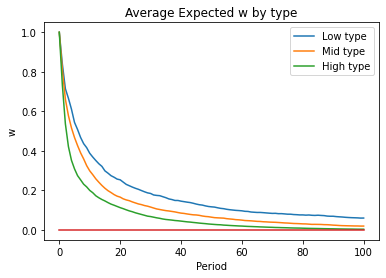

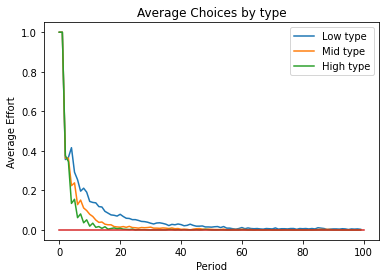

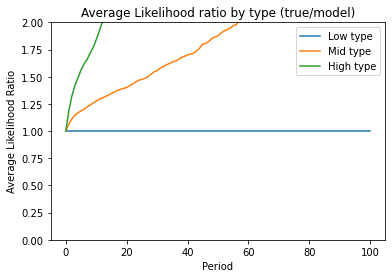

In [22]:
df_00 = truncate_lr(df_00, 3)
plot_averages(df_00, 0)

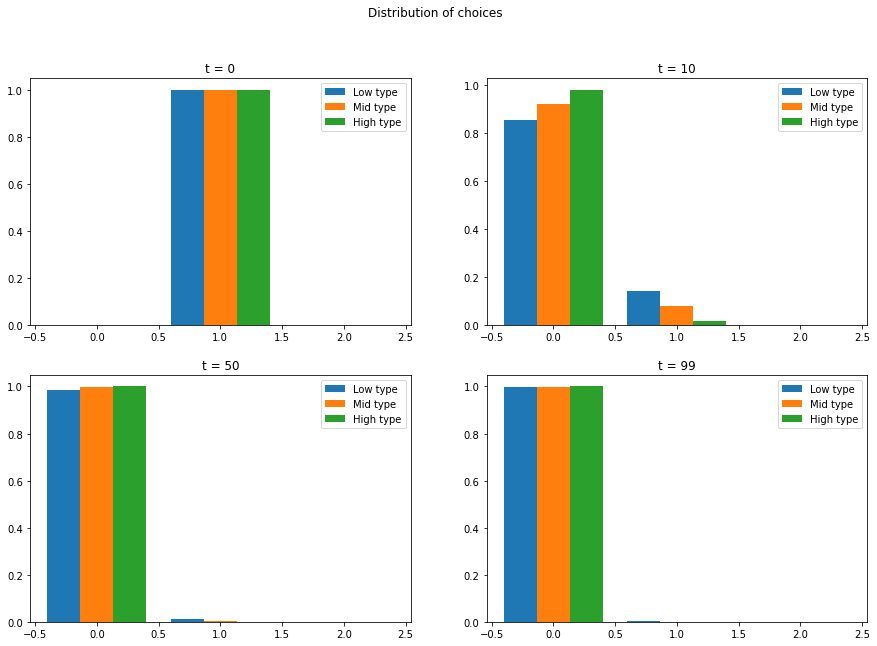

In [23]:
plot_hist(df_00, [0, 10, 50, 99])

/Users/jimenagalindo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/jimenagalindo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/jimenagalindo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/jimenagalindo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


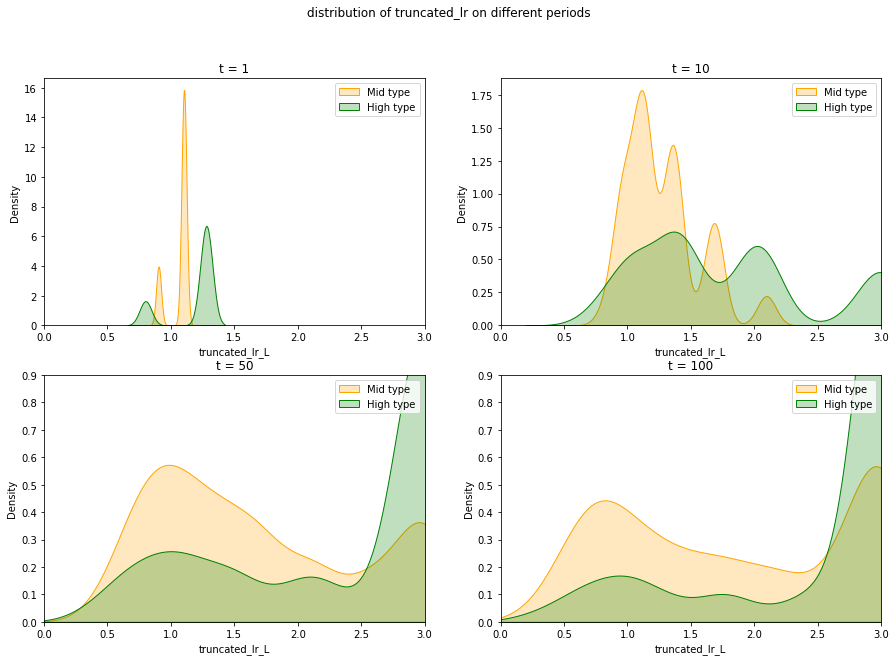

In [24]:
plot_pdf(df_00, 'lr', 3, [1, 10, 50, 100])

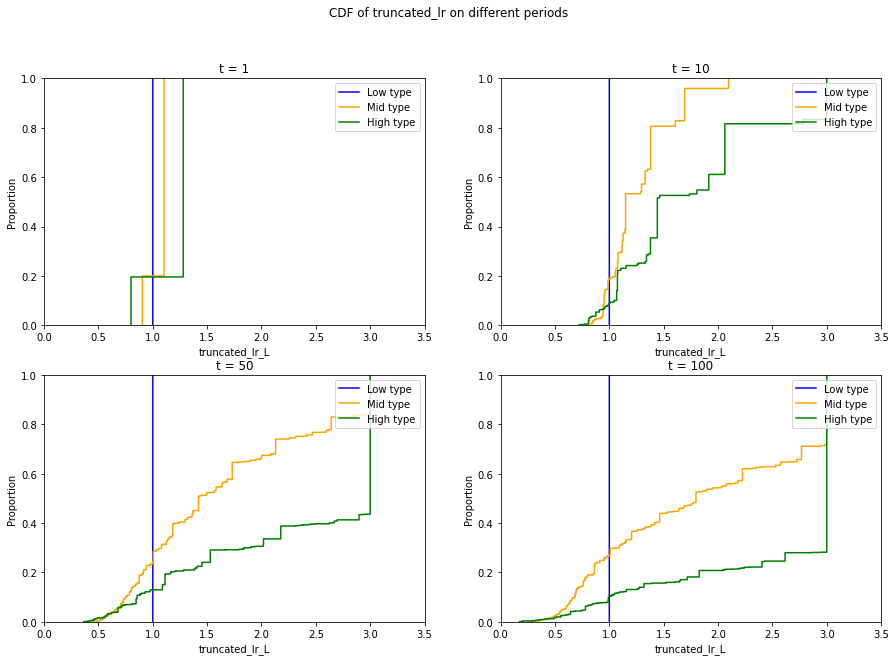

In [25]:
plot_CDF(df_00, 'lr', [1, 10, 50, 100], 1, 3)

## For a true exchange rate of $\omega_M$

In [26]:
df_10 = sim_data(1, 0, pi_0, 100, 1000, [ML, MM, MH])

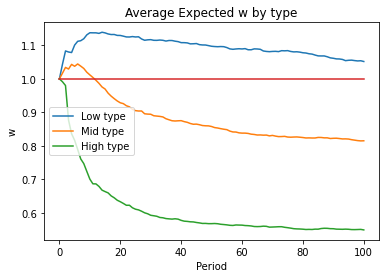

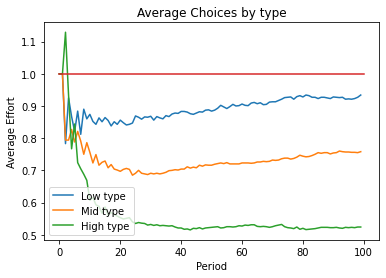

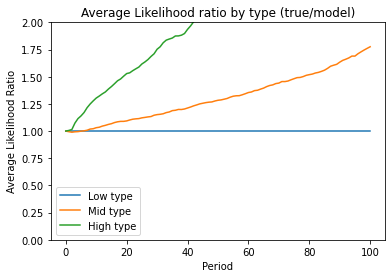

In [27]:
df_10 = truncate_lr(df_10, 3)
plot_averages(df_10, 1)

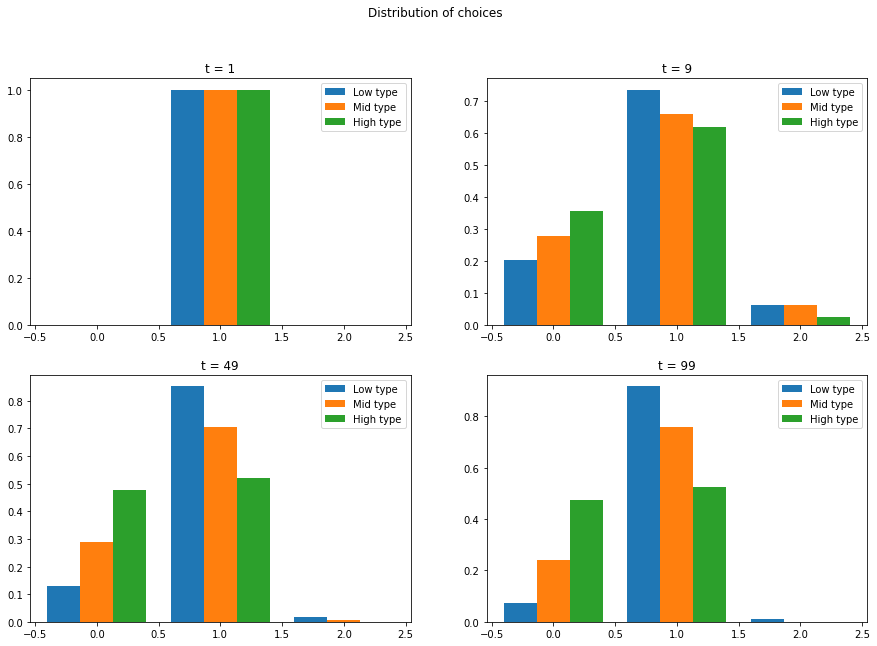

In [28]:
plot_hist(df_10, [1, 9, 49, 99])

/Users/jimenagalindo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/jimenagalindo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/jimenagalindo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/jimenagalindo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


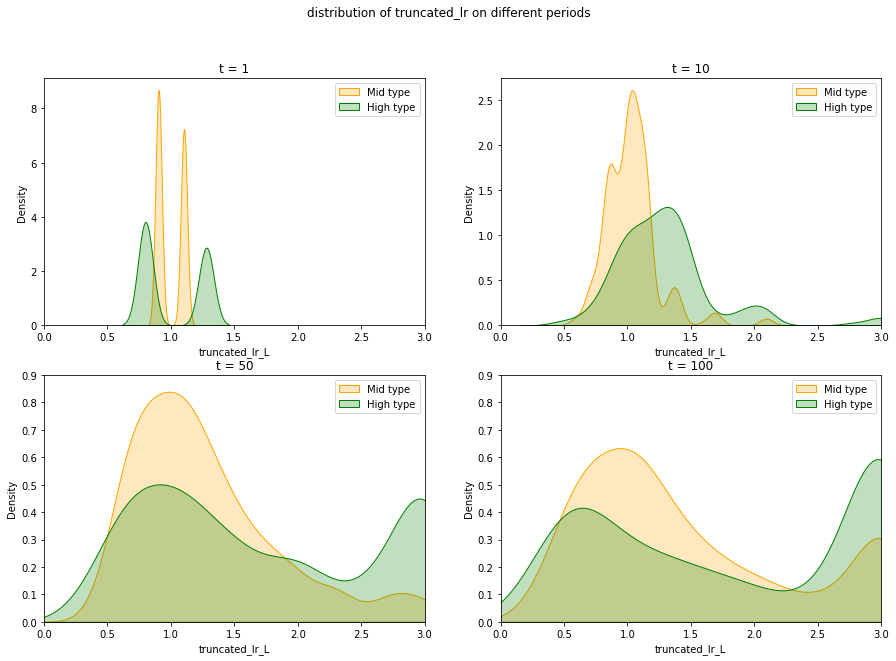

In [29]:
plot_pdf(df_10, 'lr', 3, [1, 10, 50, 100])

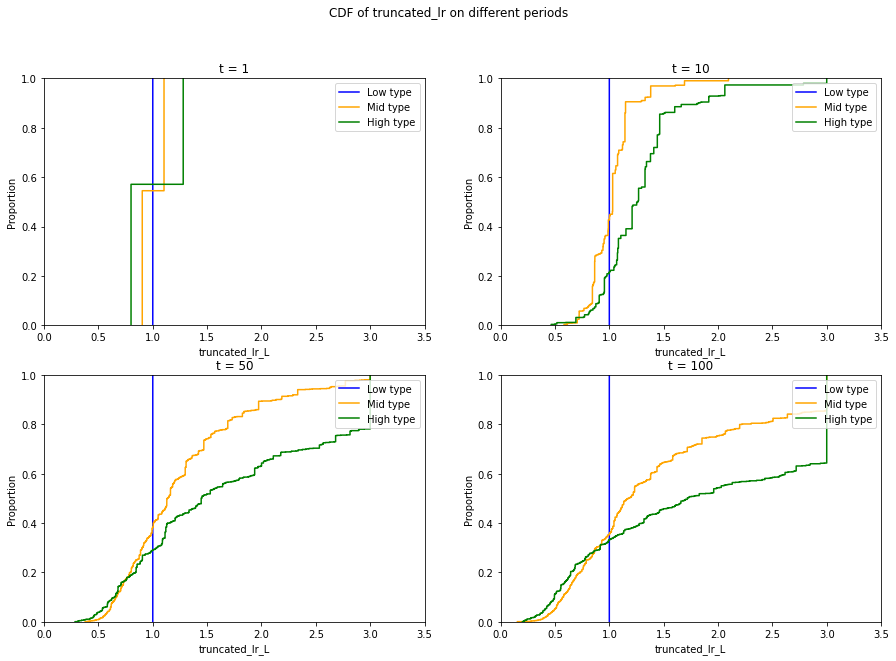

In [30]:
plot_CDF(df_10, 'lr', [1, 10, 50, 100], 1, 3)

## For a true exchange rate of $\omega_H$

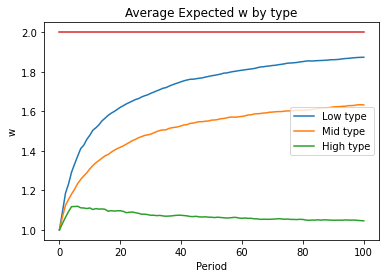

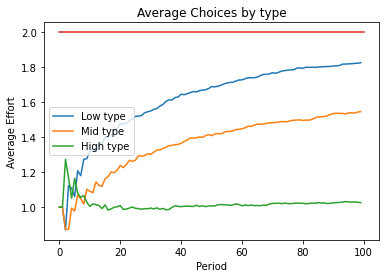

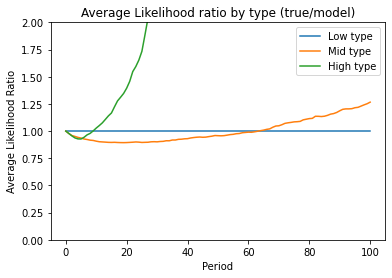

In [31]:
df_20 = sim_data(2, 0, pi_0, 100, 1000, [ML, MM, MH])

df_20 = truncate_lr(df_20, 3)
plot_averages(df_20, 2)


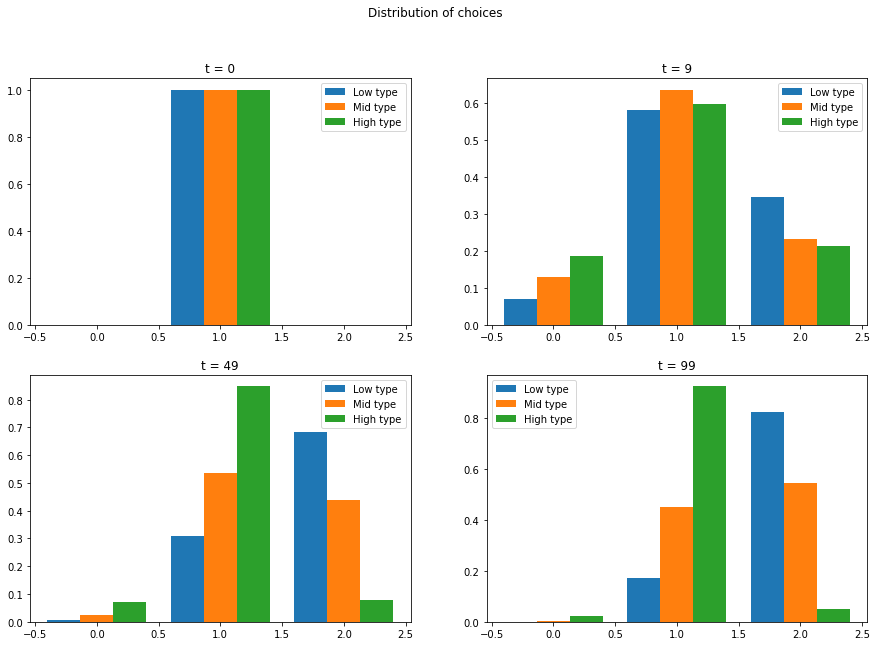

In [32]:
plot_hist(df_20, [0, 9, 49, 99])

/Users/jimenagalindo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/jimenagalindo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/jimenagalindo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/jimenagalindo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


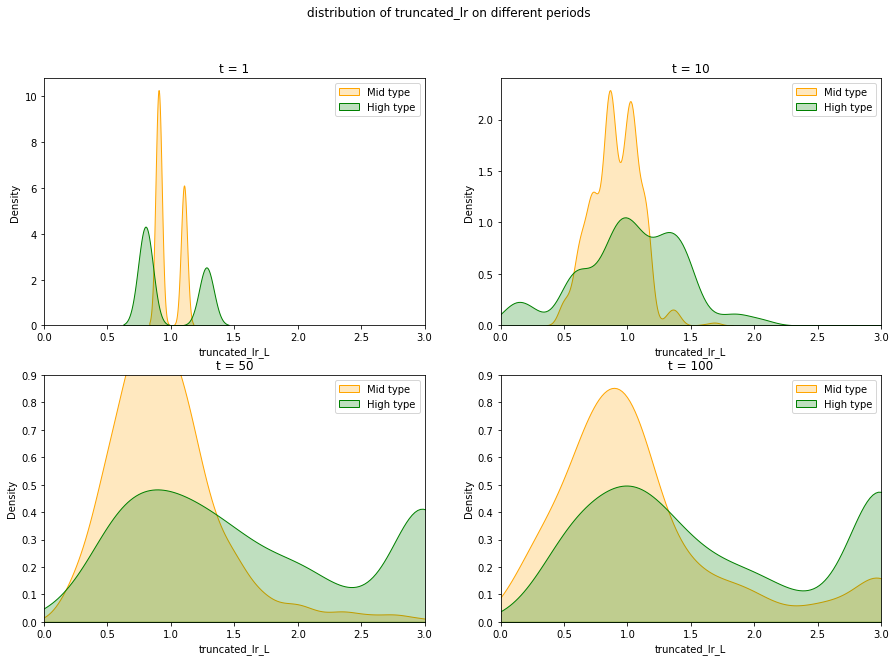

In [33]:
plot_pdf(df_20, 'lr', 3, [1, 10, 50, 100])

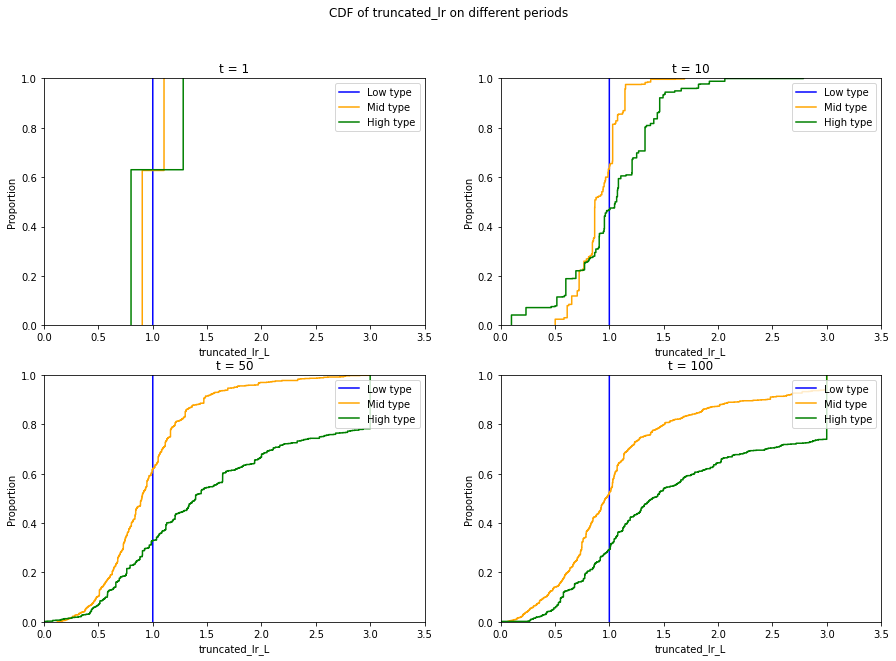

In [34]:
plot_CDF(df_20, 'lr', [1, 10, 50, 100], 1, 3)

# Case 2: When the true type is $\theta_M$

## For a true exchange rate of $\omega_L$

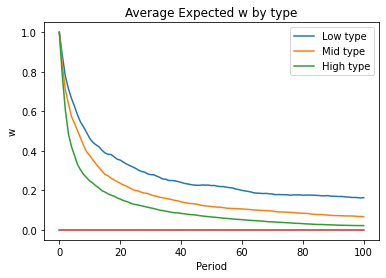

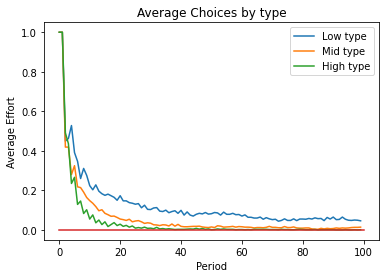

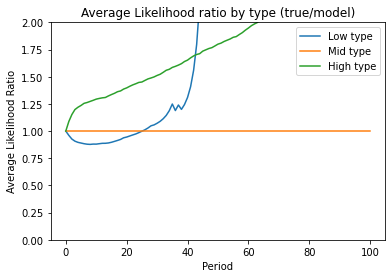

In [35]:
df_01 = sim_data(0, 1, pi_0, 100, 1000, [ML, MM, MH])

df_01 = truncate_lr(df_01, 3)
plot_averages(df_01, 0)

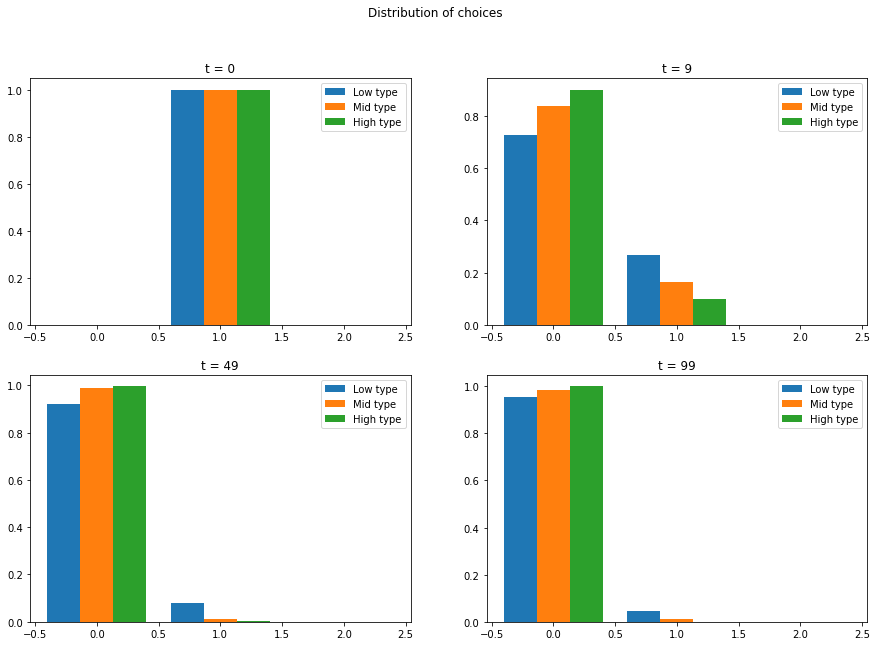

In [36]:
plot_hist(df_01, [0, 9, 49, 99])

/Users/jimenagalindo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/jimenagalindo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/jimenagalindo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/jimenagalindo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


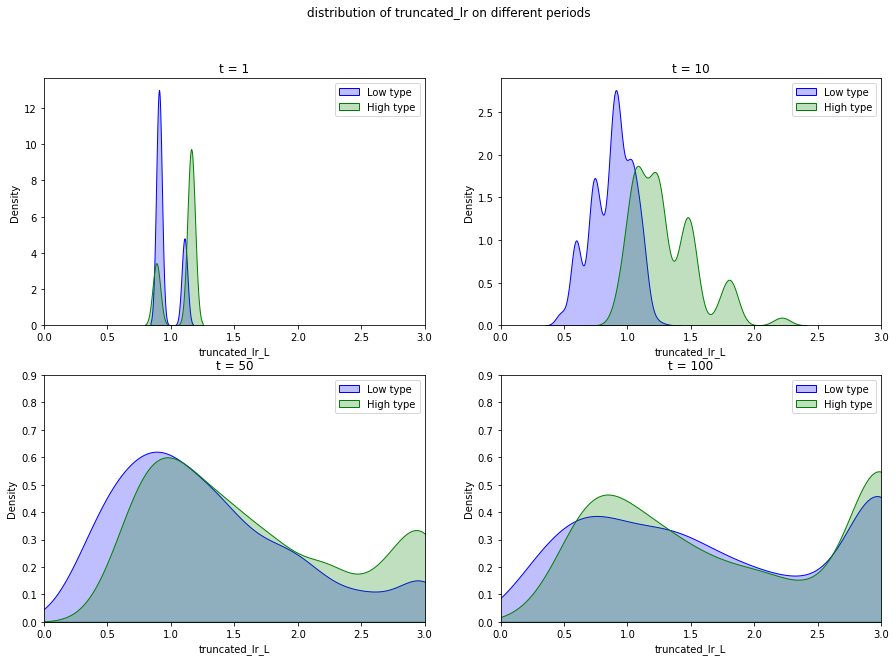

In [37]:
plot_pdf(df_01, 'lr', 3, [1, 10, 50, 100])

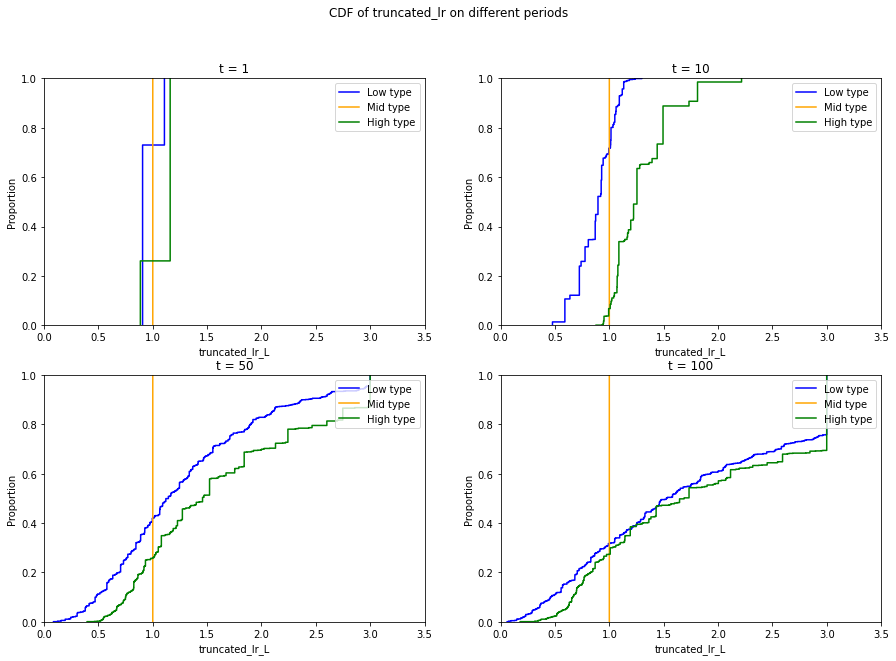

In [38]:
plot_CDF(df_01, 'lr', [1, 10, 50, 100], 1, 3)

## For a true exchange rate of $\omega_M$

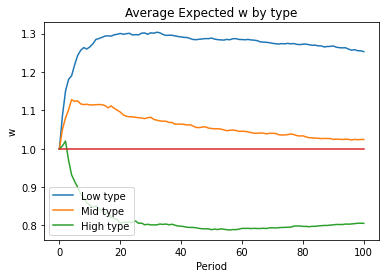

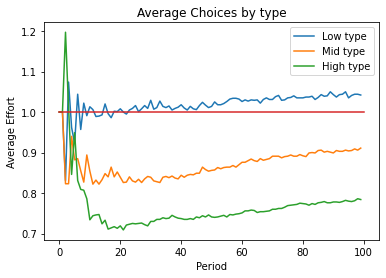

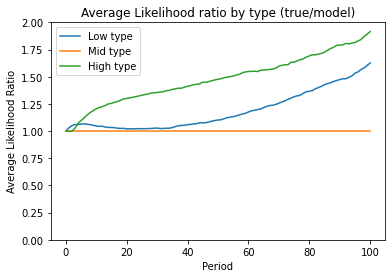

In [39]:
df_11 = sim_data(1, 1, pi_0, 100, 1000, [ML, MM, MH])

df_11 = truncate_lr(df_11, 3)
plot_averages(df_11, 1)

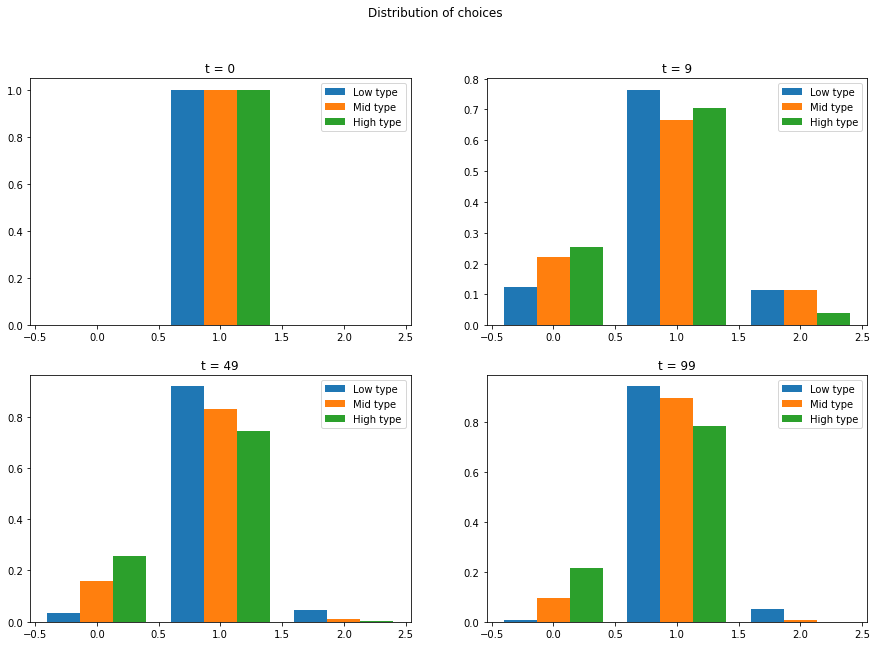

In [40]:
plot_hist(df_11, [0, 9, 49, 99])

/Users/jimenagalindo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/jimenagalindo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/jimenagalindo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/jimenagalindo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


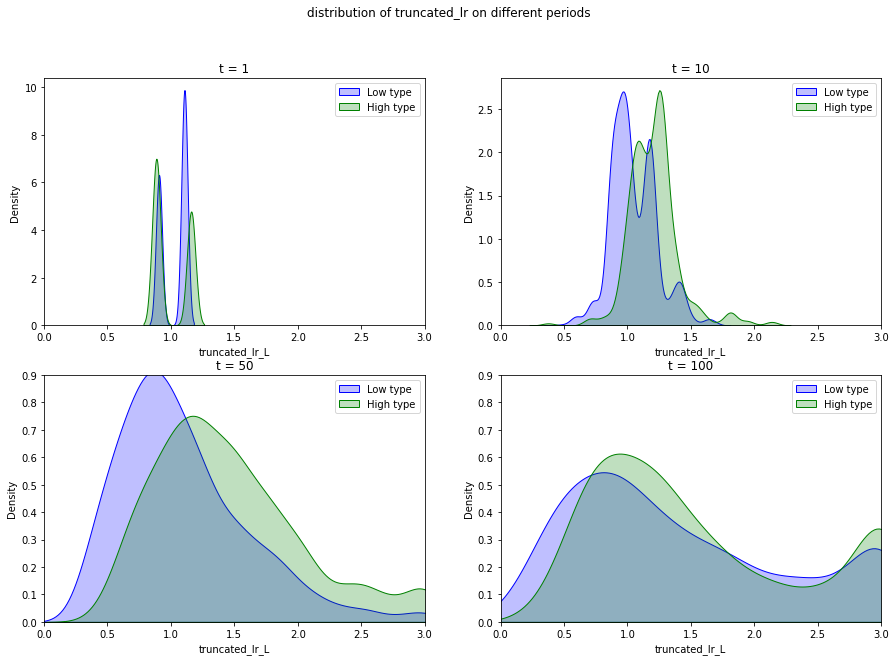

In [41]:
plot_pdf(df_11, 'lr', 3, [1, 10, 50, 100])

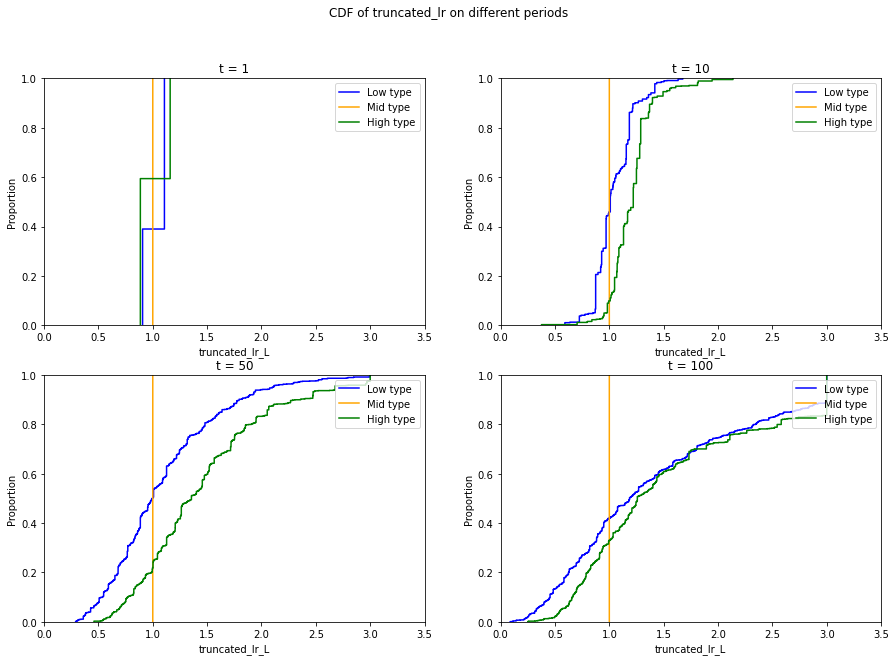

In [42]:
plot_CDF(df_11, 'lr', [1, 10, 50, 100], 1, 3)

## For a true exchange rate of $\omega_H$

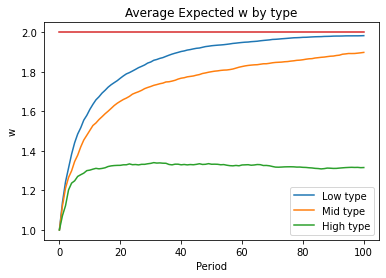

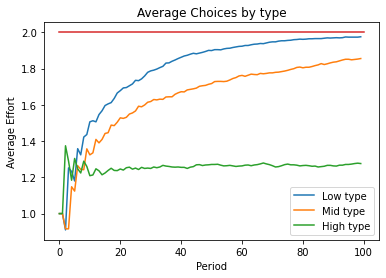

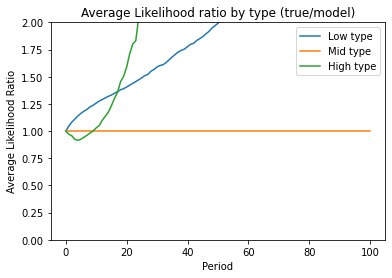

In [43]:
df_21 = sim_data(2, 1, pi_0, 100, 1000, [ML, MM, MH])

df_21 = truncate_lr(df_21, 3)
plot_averages(df_21, 2)

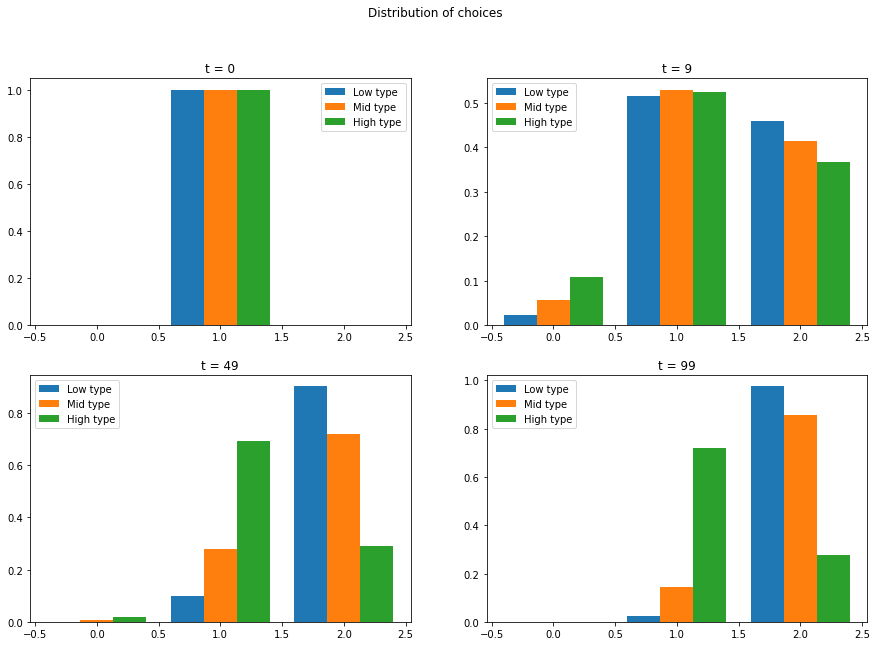

In [44]:
plot_hist(df_21, [0, 9, 49, 99])

/Users/jimenagalindo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/jimenagalindo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/jimenagalindo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/jimenagalindo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


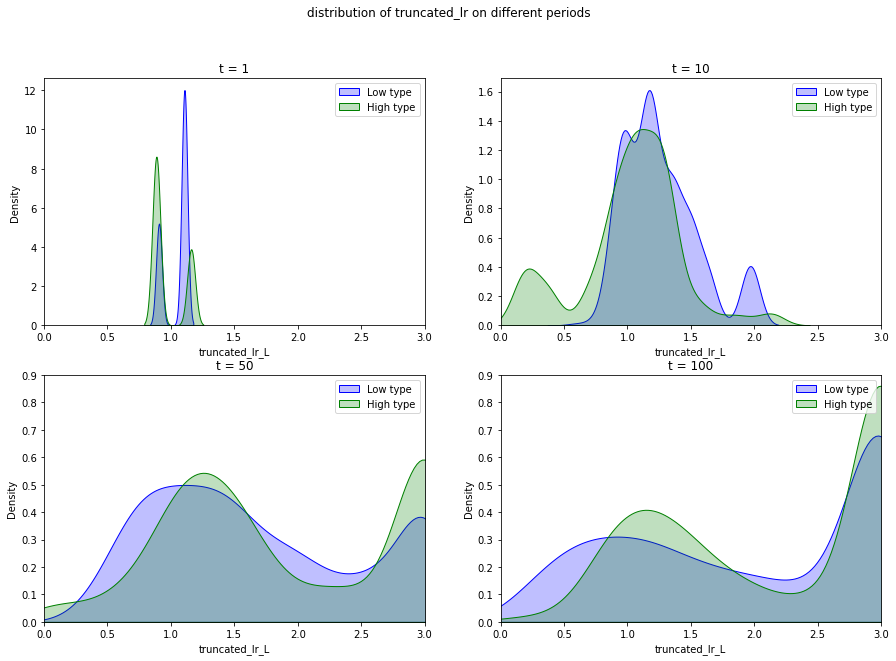

In [45]:
plot_pdf(df_21, 'lr', 3, [1, 10, 50, 100])

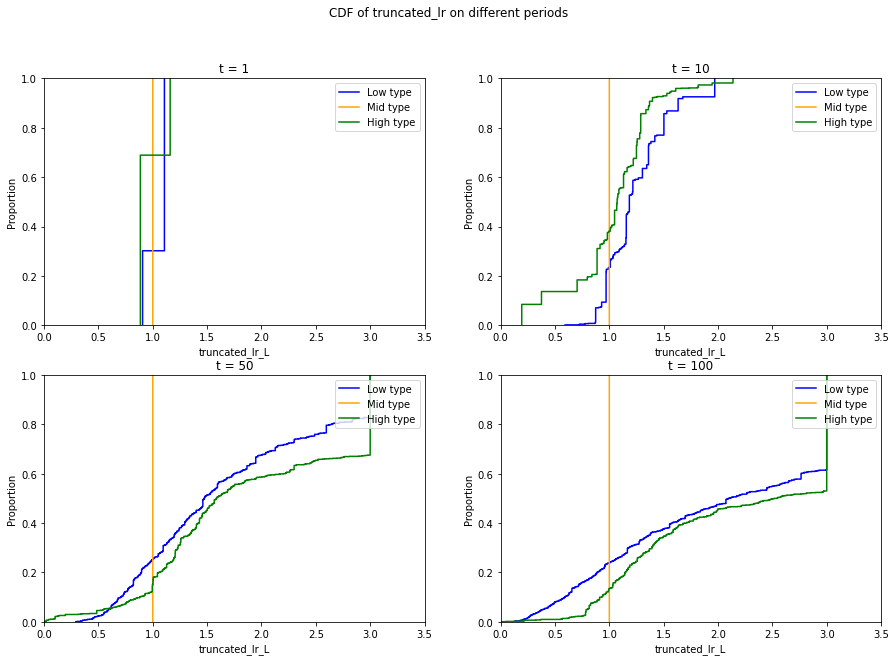

In [46]:
plot_CDF(df_21, 'lr', [1, 10, 50, 100], 1, 3)

# Case 3: When the true typr is $\theta_H$

## For a true exchange rate of $\omega_L$

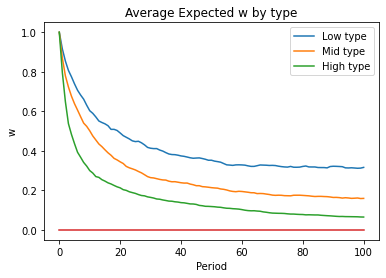

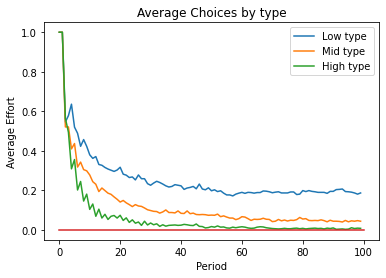

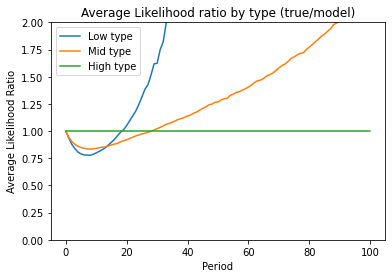

In [47]:
df_02 = sim_data(0, 2, pi_0, 100, 1000, [ML, MM, MH])

df_02 = truncate_lr(df_02, 3)
plot_averages(df_02, 0)

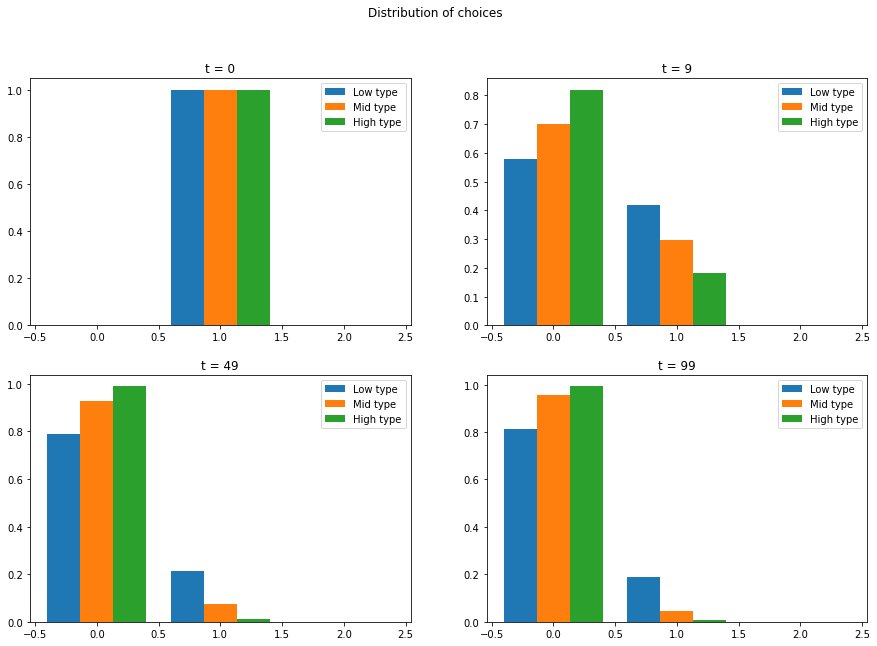

In [48]:
plot_hist(df_02, [0, 9, 49, 99])

/Users/jimenagalindo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/jimenagalindo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/jimenagalindo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/jimenagalindo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


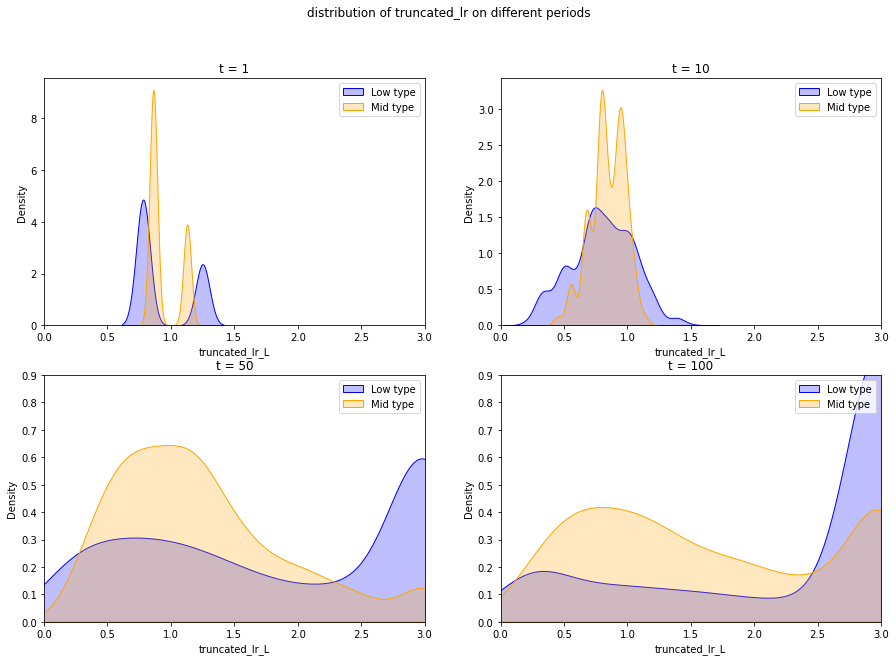

In [49]:
plot_pdf(df_02, 'lr', 3, [1, 10, 50, 100])

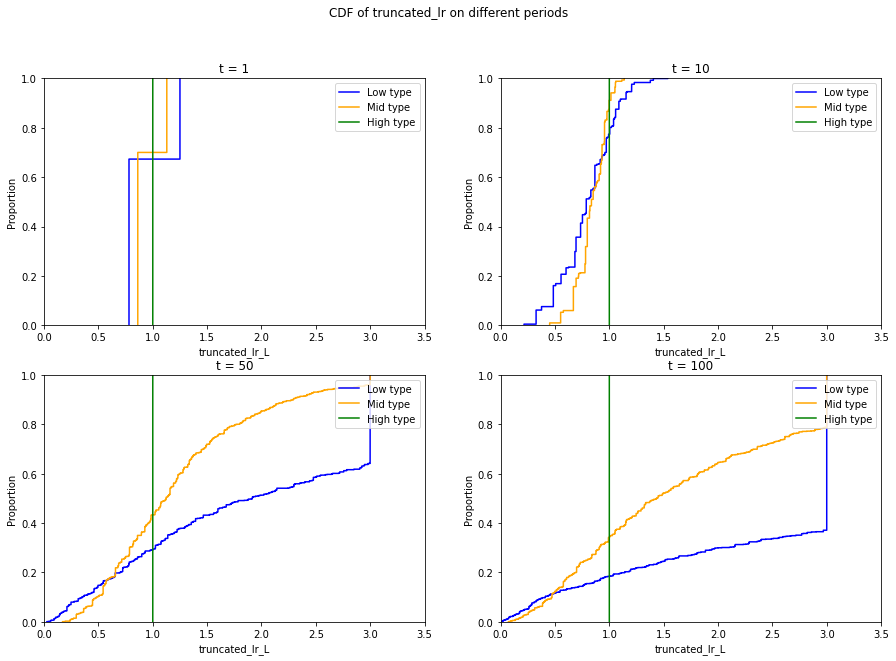

In [50]:
plot_CDF(df_02, 'lr', [1, 10, 50, 100], 1, 3)

## For a true exchange rate of $\omega_M$

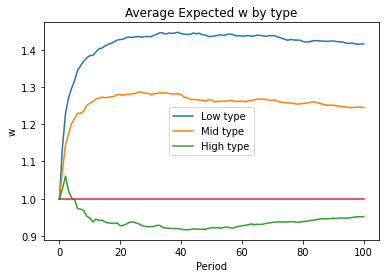

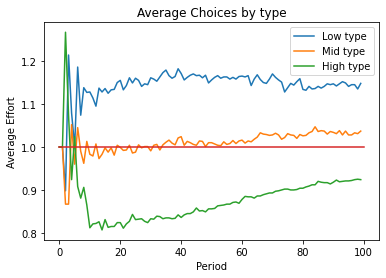

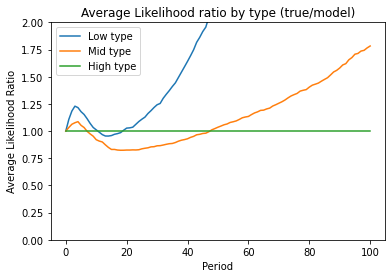

In [51]:
df_12 = sim_data(1, 2, pi_0, 100, 1000, [ML, MM, MH])

df_12 = truncate_lr(df_12, 3)
plot_averages(df_12, 1)

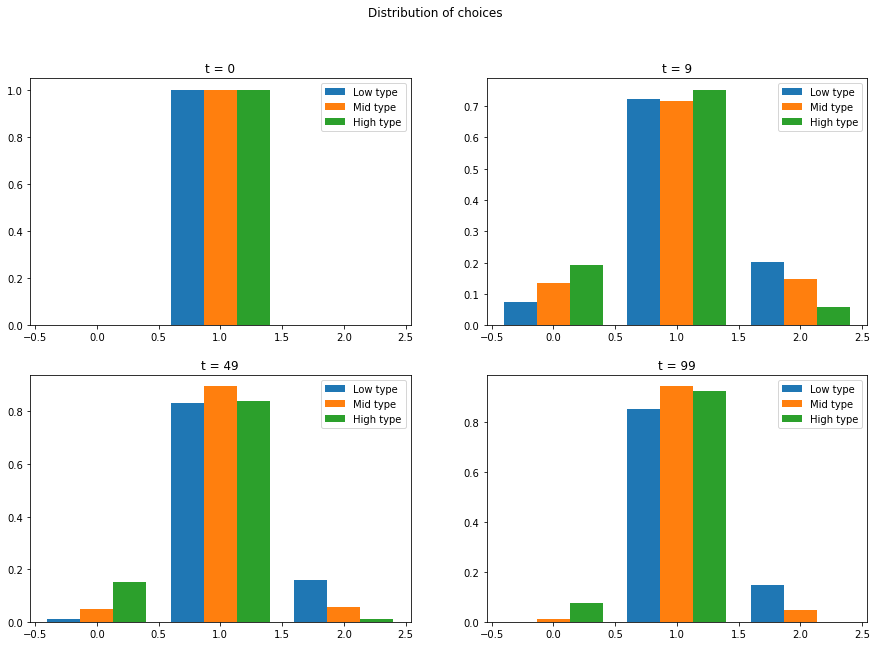

In [52]:
plot_hist(df_12, [0, 9, 49, 99])

/Users/jimenagalindo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/jimenagalindo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/jimenagalindo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/jimenagalindo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


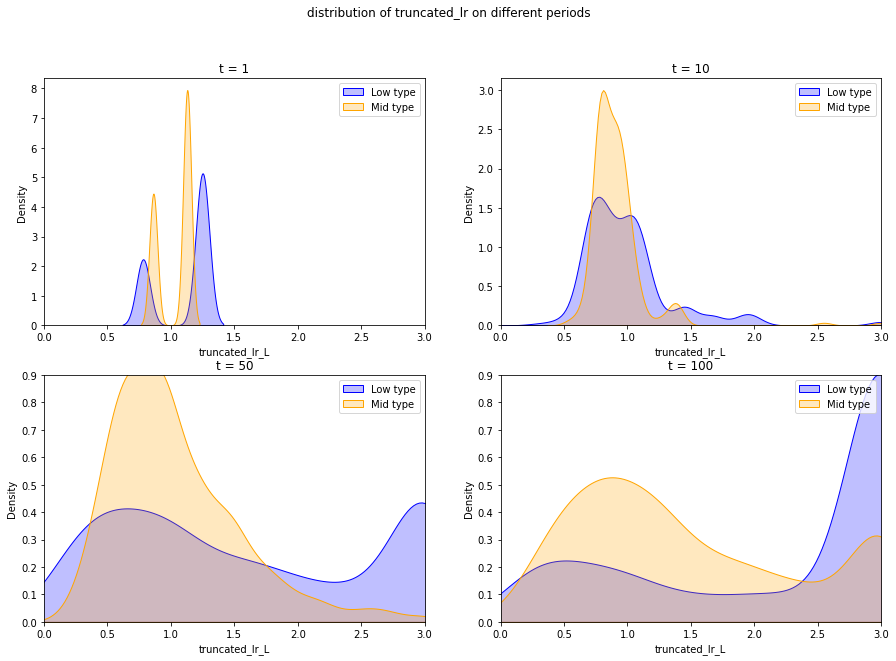

In [53]:
plot_pdf(df_12, 'lr', 3, [1, 10, 50, 100])

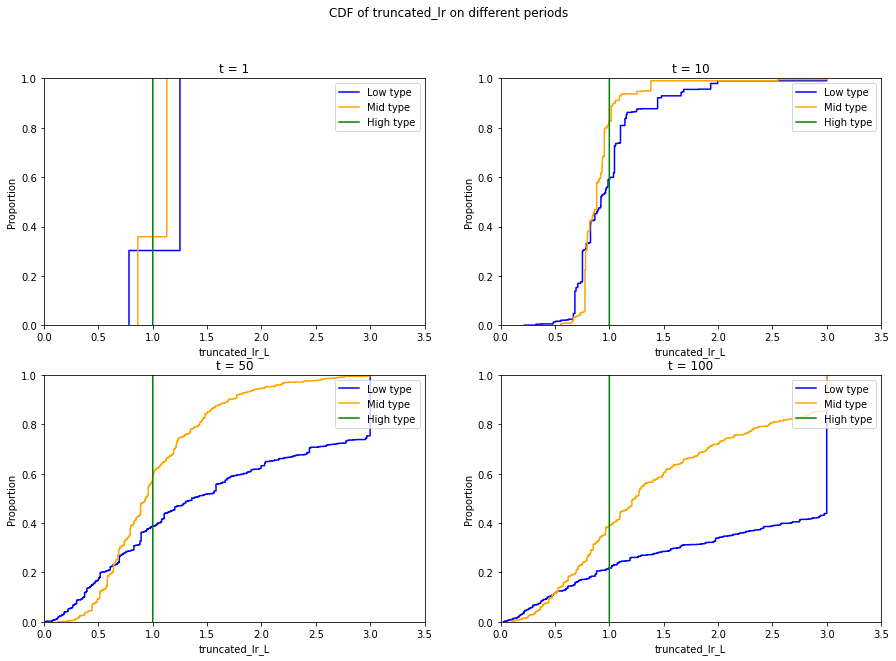

In [54]:
plot_CDF(df_12, 'lr', [1, 10, 50, 100], 1, 3)

## For a true exchange rate of $\omega_H$

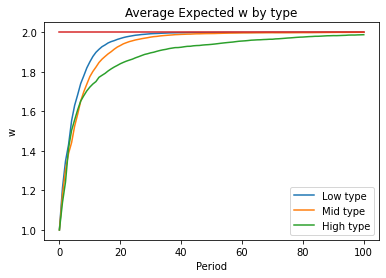

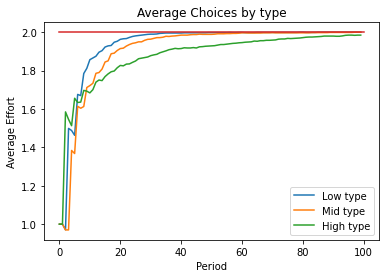

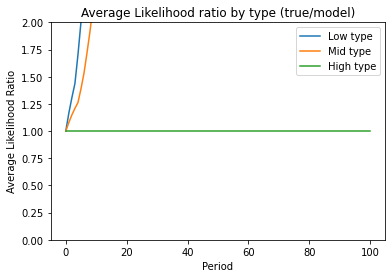

In [55]:
df_22 = sim_data(2, 2, pi_0, 100, 1000, [ML, MM, MH])

df_22 = truncate_lr(df_22, 3)
plot_averages(df_22, 2)

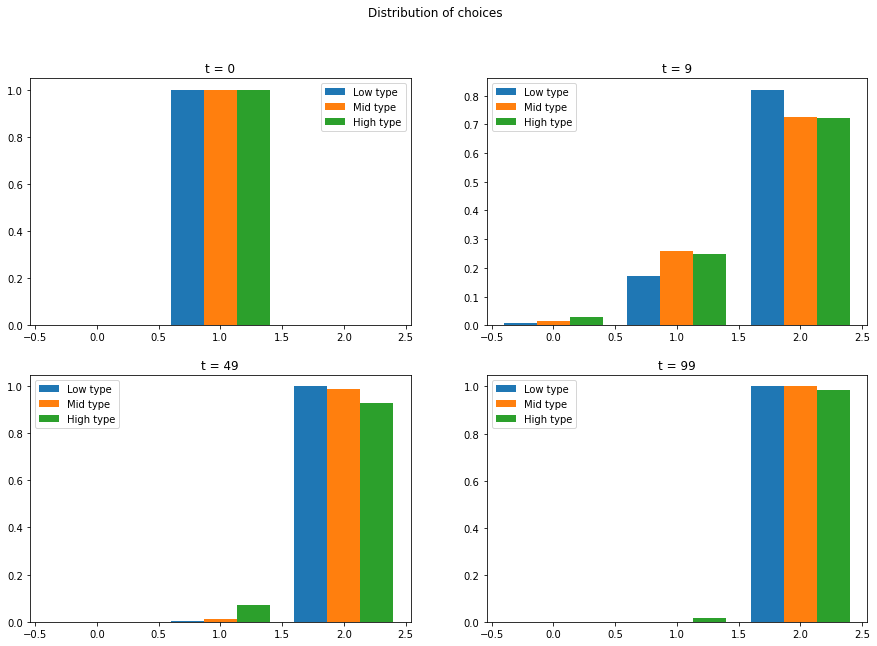

In [56]:
plot_hist(df_22, [0, 9, 49, 99])

/Users/jimenagalindo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/jimenagalindo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/jimenagalindo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/jimenagalindo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


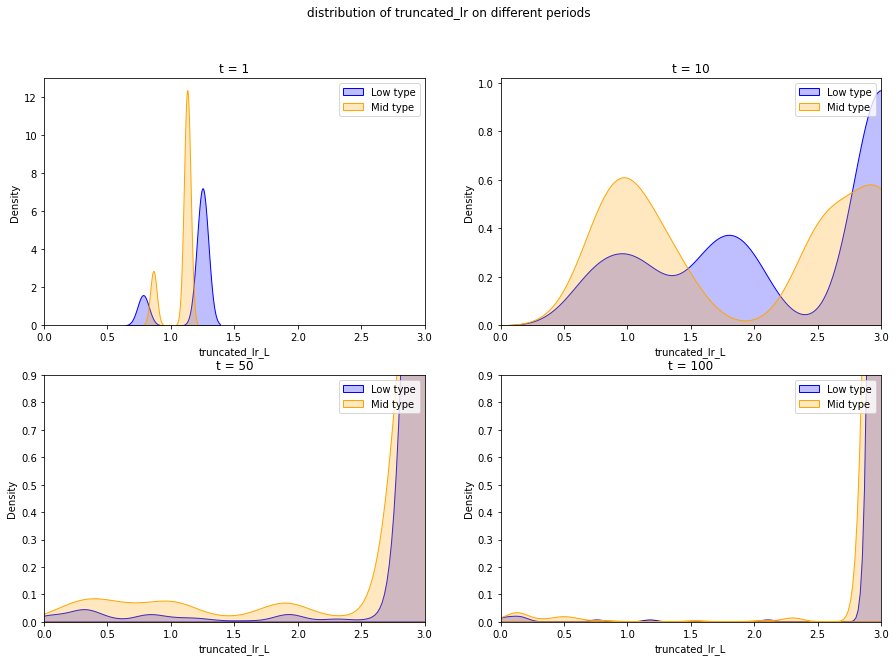

In [57]:
plot_pdf(df_22, 'lr', 3, [1, 10, 50, 100])

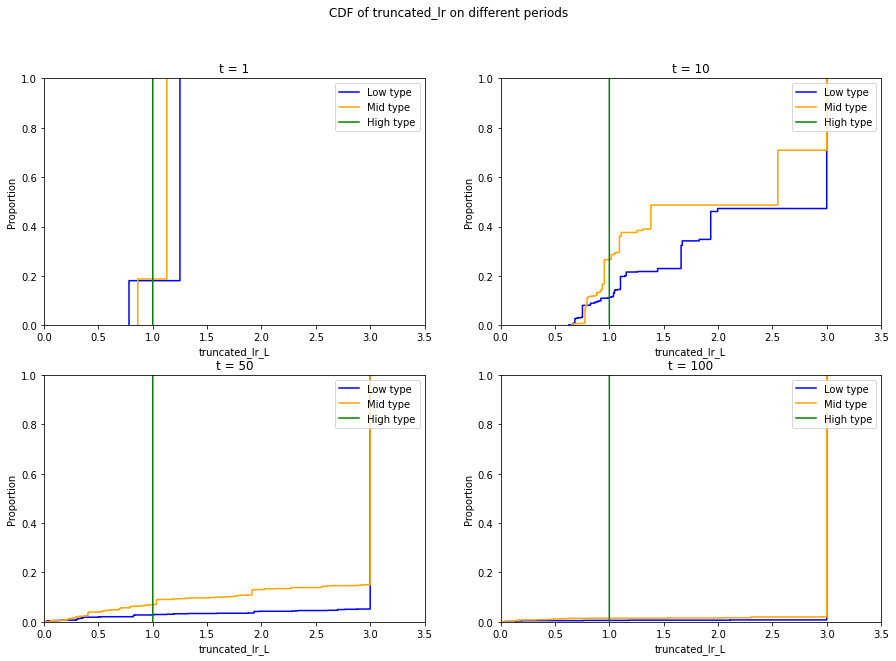

In [58]:
plot_CDF(df_22, 'lr', [1, 10, 50, 100], 1, 3)

# The Bayesian update with and without self serving attribution

# Simulation with Self-Serving Attribution bias and fully bayesian with uniform priors

In [59]:
ss_00 = ss_simulation(0, 0, 100, 1000, [ML, MM, MH], [1/3, 1/3, 1/3] , [1/3, 1/3, 1/3], [1, 1, 1.2], [1, 1, .8], [.8, 1, 1], [1.2, 1, 1])
bay_00 = ss_simulation(0, 0, 100, 1000, [ML, MM, MH], [1/3, 1/3, 1/3] , [1/3, 1/3, 1/3], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1])

ss_10 = ss_simulation(1, 0, 100, 1000, [ML, MM, MH], [1/3, 1/3, 1/3] , [1/3, 1/3, 1/3], [1, 1, 1.2], [1, 1, .8], [.8, 1, 1], [1.2, 1, 1])
bay_10 = ss_simulation(1, 0, 100, 1000, [ML, MM, MH], [1/3, 1/3, 1/3] , [1/3, 1/3, 1/3], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1])

ss_20 = ss_simulation(2, 0, 100, 1000, [ML, MM, MH], [1/3, 1/3, 1/3] , [1/3, 1/3, 1/3], [1, 1, 1.2], [1, 1, .8], [.8, 1, 1], [1.2, 1, 1])
bay_20 = ss_simulation(2, 0, 100, 1000, [ML, MM, MH], [1/3, 1/3, 1/3] , [1/3, 1/3, 1/3], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1])

ss_01 = ss_simulation(0, 1, 100, 1000, [ML, MM, MH], [1/3, 1/3, 1/3] , [1/3, 1/3, 1/3], [1, 1, 1.2], [1, 1, .8], [.8, 1, 1], [1.2, 1, 1])
bay_01 = ss_simulation(0, 1, 100, 1000, [ML, MM, MH], [1/3, 1/3, 1/3] , [1/3, 1/3, 1/3], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1])

ss_11 = ss_simulation(1, 1, 100, 1000, [ML, MM, MH], [1/3, 1/3, 1/3] , [1/3, 1/3, 1/3], [1, 1, 1.2], [1, 1, .8], [.8, 1, 1], [1.2, 1, 1])
bay_11 = ss_simulation(1, 1, 100, 1000, [ML, MM, MH], [1/3, 1/3, 1/3] , [1/3, 1/3, 1/3], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1])

ss_21 = ss_simulation(2, 1, 100, 1000, [ML, MM, MH], [1/3, 1/3, 1/3] , [1/3, 1/3, 1/3], [1, 1, 1.2], [1, 1, .8], [.8, 1, 1], [1.2, 1, 1])
bay_21 = ss_simulation(2, 1, 100, 1000, [ML, MM, MH], [1/3, 1/3, 1/3] , [1/3, 1/3, 1/3], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1])

ss_02 = ss_simulation(0, 2, 100, 1000, [ML, MM, MH], [1/3, 1/3, 1/3] , [1/3, 1/3, 1/3], [1, 1, 1.2], [1, 1, .8], [.8, 1, 1], [1.2, 1, 1])
bay_02 = ss_simulation(0, 2, 100, 1000, [ML, MM, MH], [1/3, 1/3, 1/3] , [1/3, 1/3, 1/3], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1])

ss_12 = ss_simulation(1, 2, 100, 1000, [ML, MM, MH], [1/3, 1/3, 1/3] , [1/3, 1/3, 1/3], [1, 1, 1.2], [1, 1, .8], [.8, 1, 1], [1.2, 1, 1])
bay_12 = ss_simulation(1, 2, 100, 1000, [ML, MM, MH], [1/3, 1/3, 1/3] , [1/3, 1/3, 1/3], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1])

ss_22 = ss_simulation(2, 2, 100, 1000, [ML, MM, MH], [1/3, 1/3, 1/3] , [1/3, 1/3, 1/3], [1, 1, 1.2], [1, 1, .8], [.8, 1, 1], [1.2, 1, 1])
bay_22 = ss_simulation(2, 2, 100, 1000, [ML, MM, MH], [1/3, 1/3, 1/3] , [1/3, 1/3, 1/3], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1])


In [60]:
ss_00

,,ew,eth,choice
id,year,,,
0,0,1.000000e+00,1.000000,1.0
1,0,1.000000e+00,1.000000,1.0
2,0,1.000000e+00,1.000000,1.0
3,0,1.000000e+00,1.000000,1.0
4,0,1.000000e+00,1.000000,1.0
...,...,...,...,...
995,100,4.605043e-09,1.995805,NaN
996,100,2.800882e-09,1.995805,NaN
997,100,4.735850e-10,1.992773,NaN


## Plots case by case

Text(0.5, 1.0, 'Average choice')

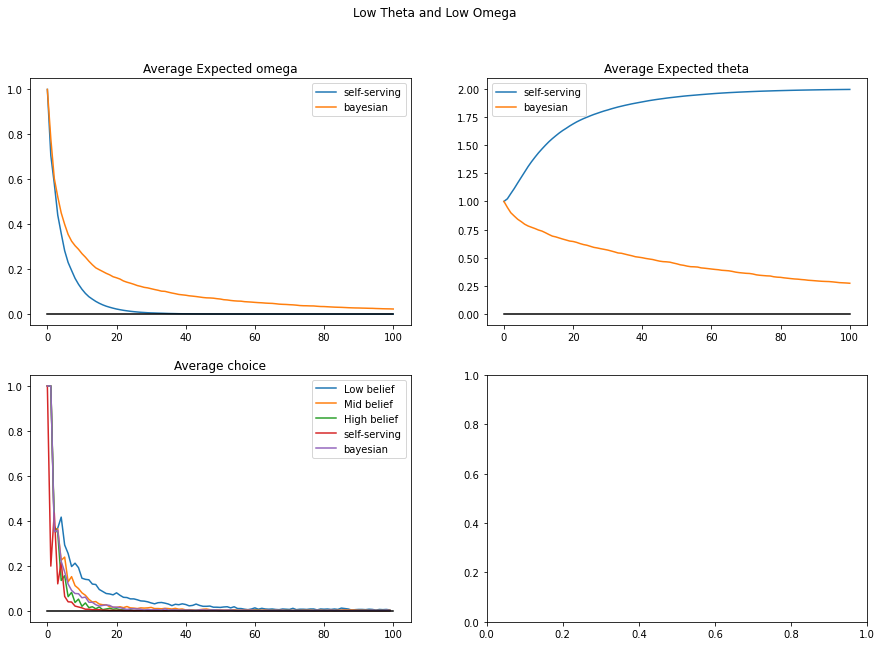

In [61]:
avg_ss = ss_00.groupby('year').mean()
avg_bay = bay_00.groupby('year').mean()
avg_df = df_00.groupby('year').mean()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('Low Theta and Low Omega')

fig.set_figheight(10)
fig.set_figwidth(15)

ax1.plot(avg_ss['ew'], label = "self-serving")
ax1.plot(avg_bay['ew'], label = "bayesian")
ax1.plot(0*np.ones(len(avg_ss['ew'])), color = 'black')
ax1.legend()
ax1.set_title('Average Expected omega')

ax2.plot(avg_ss['eth'], label = "self-serving")
ax2.plot(avg_bay['eth'], label = "bayesian")
ax2.plot(0*np.ones(len(avg_ss['eth'])), color = 'black')
ax2.legend()
ax2.set_title('Average Expected theta')

ax3.plot(avg_df['choice_L'], label = "Low belief")
ax3.plot(avg_df['choice_M'], label = "Mid belief")
ax3.plot(avg_df['choice_H'], label = "High belief")
ax3.plot(avg_ss['choice'], label = "self-serving")
ax3.plot(avg_bay['choice'], label = "bayesian")
ax3.plot(0*np.ones(len(avg_ss['choice'])), color = 'black')
ax3.legend()
ax3.set_title('Average choice')


Text(0.5, 1.0, 'choices at t=100')

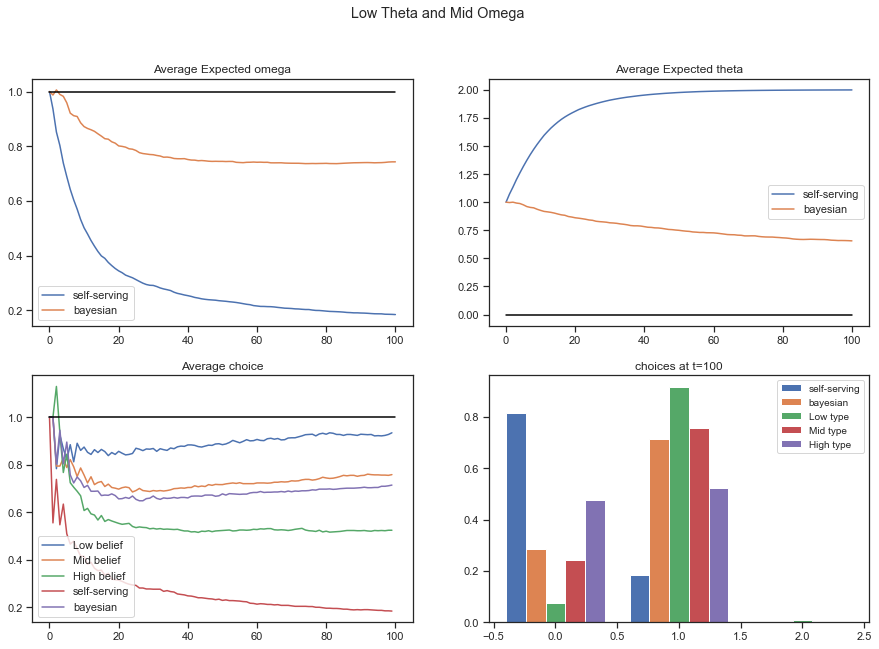

In [140]:
avg_ss = ss_10.groupby('year').mean()
avg_bay = bay_10.groupby('year').mean()
avg_df = df_10.groupby('year').mean()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('Low Theta and Mid Omega')

fig.set_figheight(10)
fig.set_figwidth(15)

ax1.plot(avg_ss['ew'], label = "self-serving")
ax1.plot(avg_bay['ew'], label = "bayesian")
ax1.plot(1*np.ones(len(avg_ss['ew'])), color = 'black')
ax1.legend()
ax1.set_title('Average Expected omega')

ax2.plot(avg_ss['eth'], label = "self-serving")
ax2.plot(avg_bay['eth'], label = "bayesian")
ax2.plot(0*np.ones(len(avg_ss['eth'])), color = 'black')
ax2.legend()
ax2.set_title('Average Expected theta')

ax3.plot(avg_df['choice_L'], label = "Low belief")
ax3.plot(avg_df['choice_M'], label = "Mid belief")
ax3.plot(avg_df['choice_H'], label = "High belief")
ax3.plot(avg_ss['choice'], label = "self-serving")
ax3.plot(avg_bay['choice'], label = "bayesian")
ax3.plot(1*np.ones(len(avg_ss['choice'])), color = 'black')
ax3.legend()
ax3.set_title('Average choice')

x1 = [ss_10.loc[(slice(None), 99), 'choice'], 
      bay_10.loc[(slice(None), 99), 'choice'], 
      df_10.loc[(slice(None), 99), 'choice_L'], 
      df_10.loc[(slice(None), 99), 'choice_M'], 
      df_10.loc[(slice(None), 99), 'choice_H']]
ax4.hist(x1, [0, 1, 2, 3], density=True, histtype='bar', label=['self-serving', 'bayesian','Low type', 'Mid type', 'High type'], align='left')
ax4.legend(prop={'size': 10})
ax4.set_title('choices at t=100')

Text(0.5, 1.0, 'choices at t=100')

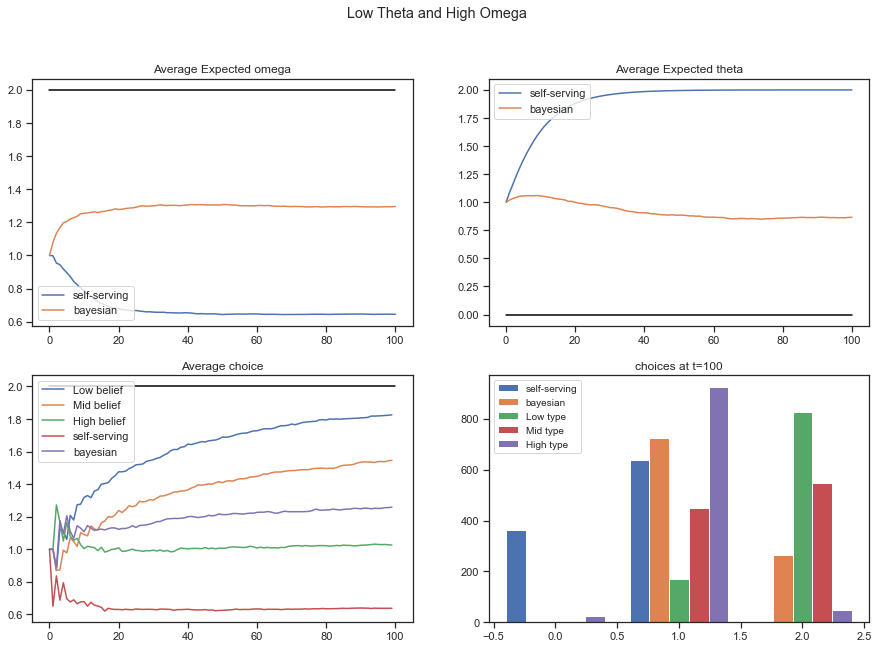

In [139]:
avg_ss = ss_20.groupby('year').mean()
avg_bay = bay_20.groupby('year').mean()
avg_df = df_20.groupby('year').mean()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('Low Theta and High Omega')

fig.set_figheight(10)
fig.set_figwidth(15)

ax1.plot(avg_ss['ew'], label = "self-serving")
ax1.plot(avg_bay['ew'], label = "bayesian")
ax1.plot(2*np.ones(len(avg_ss['ew'])), color = 'black')
ax1.legend()
ax1.set_title('Average Expected omega')

ax2.plot(avg_ss['eth'], label = "self-serving")
ax2.plot(avg_bay['eth'], label = "bayesian")
ax2.plot(0*np.ones(len(avg_ss['eth'])), color = 'black')
ax2.legend()
ax2.set_title('Average Expected theta')

ax3.plot(avg_df['choice_L'], label = "Low belief")
ax3.plot(avg_df['choice_M'], label = "Mid belief")
ax3.plot(avg_df['choice_H'], label = "High belief")
ax3.plot(avg_ss['choice'], label = "self-serving")
ax3.plot(avg_bay['choice'], label = "bayesian")
ax3.plot(2*np.ones(len(avg_ss['choice'])), color = 'black')
ax3.legend()
ax3.set_title('Average choice')


x1 = [ss_20.loc[(slice(None), 99), 'choice'], 
      bay_20.loc[(slice(None), 99), 'choice'], 
      df_20.loc[(slice(None), 99), 'choice_L'], 
      df_20.loc[(slice(None), 99), 'choice_M'], 
      df_20.loc[(slice(None), 99), 'choice_H']]
ax4.hist(x1, [0, 1, 2, 3], density=False, histtype='bar', label=['self-serving', 'bayesian','Low type', 'Mid type', 'High type'], align='left')
ax4.legend(prop={'size': 10})
ax4.set_title('choices at t=100')

Text(0.5, 1.0, 'choices at t=100')

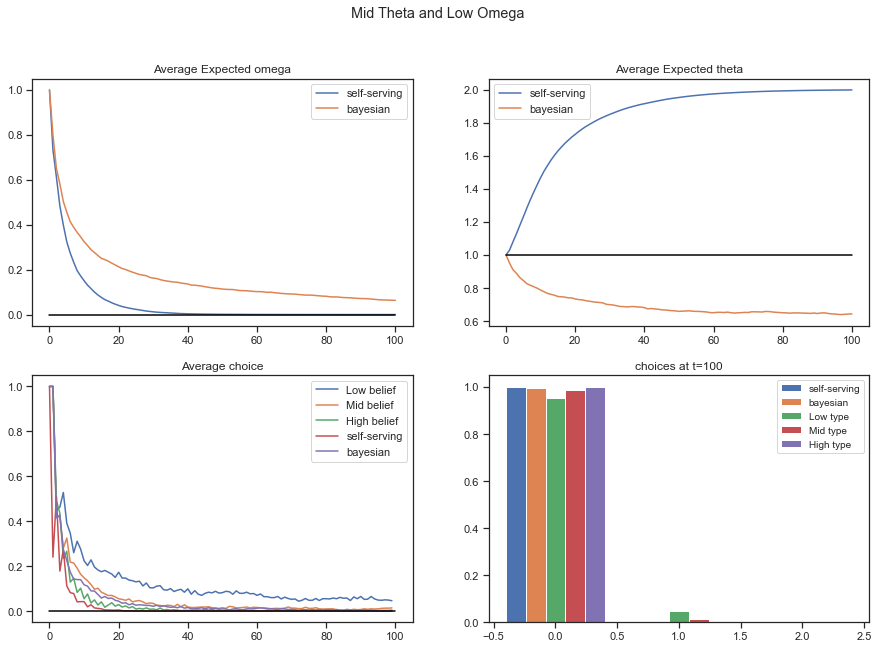

In [137]:
avg_ss = ss_01.groupby('year').mean()
avg_bay = bay_01.groupby('year').mean()
avg_df = df_01.groupby('year').mean()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('Mid Theta and Low Omega')

fig.set_figheight(10)
fig.set_figwidth(15)

ax1.plot(avg_ss['ew'], label = "self-serving")
ax1.plot(avg_bay['ew'], label = "bayesian")
ax1.plot(0*np.ones(len(avg_ss['ew'])), color = 'black')
ax1.legend()
ax1.set_title('Average Expected omega')

ax2.plot(avg_ss['eth'], label = "self-serving")
ax2.plot(avg_bay['eth'], label = "bayesian")
ax2.plot(1*np.ones(len(avg_ss['eth'])), color = 'black')
ax2.legend()
ax2.set_title('Average Expected theta')

ax3.plot(avg_df['choice_L'], label = "Low belief")
ax3.plot(avg_df['choice_M'], label = "Mid belief")
ax3.plot(avg_df['choice_H'], label = "High belief")
ax3.plot(avg_ss['choice'], label = "self-serving")
ax3.plot(avg_bay['choice'], label = "bayesian")
ax3.plot(0*np.ones(len(avg_ss['choice'])), color = 'black')
ax3.legend()
ax3.set_title('Average choice')

x1 = [ss_01.loc[(slice(None), 99), 'choice'], 
      bay_01.loc[(slice(None), 99), 'choice'], 
      df_01.loc[(slice(None), 99), 'choice_L'], 
      df_01.loc[(slice(None), 99), 'choice_M'], 
      df_01.loc[(slice(None), 99), 'choice_H']]
ax4.hist(x1, [0, 1, 2, 3], density=True, histtype='bar', label=['self-serving', 'bayesian','Low type', 'Mid type', 'High type'], align='left')
ax4.legend(prop={'size': 10})
ax4.set_title('choices at t=100')

Text(0.5, 1.0, 'choices at t=100')

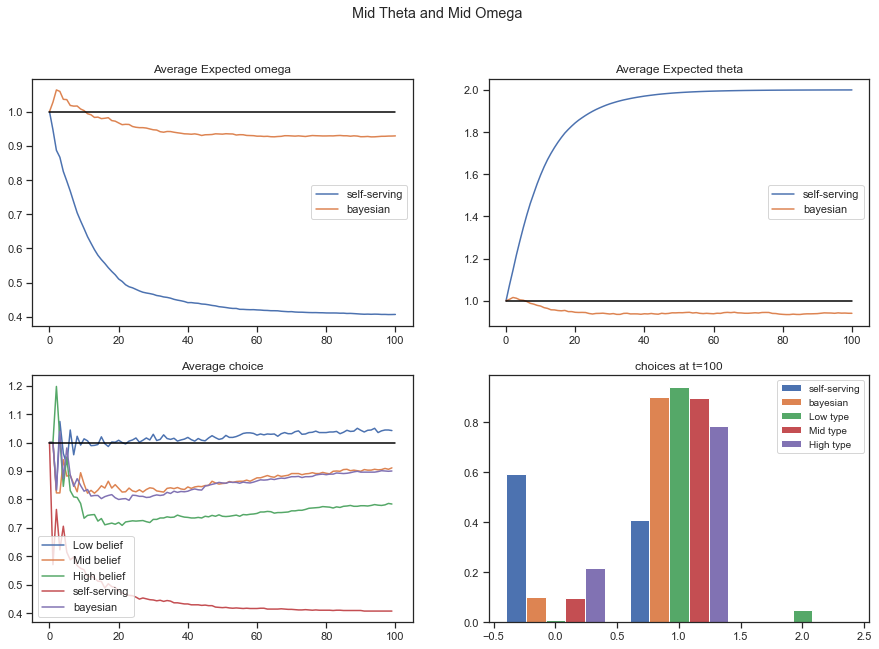

In [136]:
avg_ss = ss_11.groupby('year').mean()
avg_bay = bay_11.groupby('year').mean()
avg_df = df_11.groupby('year').mean()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('Mid Theta and Mid Omega')

fig.set_figheight(10)
fig.set_figwidth(15)

ax1.plot(avg_ss['ew'], label = "self-serving")
ax1.plot(avg_bay['ew'], label = "bayesian")
ax1.plot(1*np.ones(len(avg_ss['ew'])), color = 'black')
ax1.legend()
ax1.set_title('Average Expected omega')

ax2.plot(avg_ss['eth'], label = "self-serving")
ax2.plot(avg_bay['eth'], label = "bayesian")
ax2.plot(1*np.ones(len(avg_ss['eth'])), color = 'black')
ax2.legend()
ax2.set_title('Average Expected theta')

ax3.plot(avg_df['choice_L'], label = "Low belief")
ax3.plot(avg_df['choice_M'], label = "Mid belief")
ax3.plot(avg_df['choice_H'], label = "High belief")
ax3.plot(avg_ss['choice'], label = "self-serving")
ax3.plot(avg_bay['choice'], label = "bayesian")
ax3.plot(1*np.ones(len(avg_ss['choice'])), color = 'black')
ax3.legend()
ax3.set_title('Average choice')

x1 = [ss_11.loc[(slice(None), 99), 'choice'], 
      bay_11.loc[(slice(None), 99), 'choice'], 
      df_11.loc[(slice(None), 99), 'choice_L'], 
      df_11.loc[(slice(None), 99), 'choice_M'], 
      df_11.loc[(slice(None), 99), 'choice_H']]
ax4.hist(x1, [0, 1, 2, 3], density=True, histtype='bar', label=['self-serving', 'bayesian','Low type', 'Mid type', 'High type'], align='left')
ax4.legend(prop={'size': 10})
ax4.set_title('choices at t=100')

Text(0.5, 1.0, 'choices at t=100')

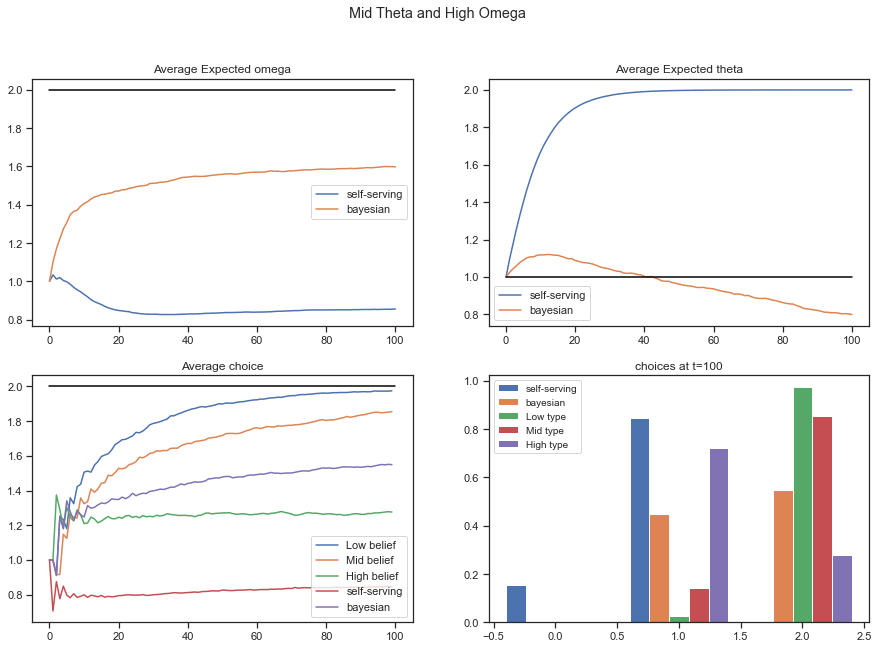

In [135]:
avg_ss = ss_21.groupby('year').mean()
avg_bay = bay_21.groupby('year').mean()
avg_df = df_21.groupby('year').mean()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('Mid Theta and High Omega')

fig.set_figheight(10)
fig.set_figwidth(15)

ax1.plot(avg_ss['ew'], label = "self-serving")
ax1.plot(avg_bay['ew'], label = "bayesian")
ax1.plot(2*np.ones(len(avg_ss['ew'])), color = 'black')
ax1.legend()
ax1.set_title('Average Expected omega')

ax2.plot(avg_ss['eth'], label = "self-serving")
ax2.plot(avg_bay['eth'], label = "bayesian")
ax2.plot(1*np.ones(len(avg_ss['eth'])), color = 'black')
ax2.legend()
ax2.set_title('Average Expected theta')

ax3.plot(avg_df['choice_L'], label = "Low belief")
ax3.plot(avg_df['choice_M'], label = "Mid belief")
ax3.plot(avg_df['choice_H'], label = "High belief")
ax3.plot(avg_ss['choice'], label = "self-serving")
ax3.plot(avg_bay['choice'], label = "bayesian")
ax3.plot(2*np.ones(len(avg_ss['choice'])), color = 'black')
ax3.legend()
ax3.set_title('Average choice')

x1 = [ss_21.loc[(slice(None), 99), 'choice'], bay_21.loc[(slice(None), 99), 'choice'], df_21.loc[(slice(None), 99), 'choice_L'], df_21.loc[(slice(None), 99), 'choice_M'], df_21.loc[(slice(None), 99), 'choice_H']]
ax4.hist(x1, [0, 1, 2, 3], density=True, histtype='bar', label=['self-serving', 'bayesian','Low type', 'Mid type', 'High type'], align='left')
ax4.legend(prop={'size': 10})
ax4.set_title('choices at t=100')

Text(0.5, 1.0, 'choices at t=100')

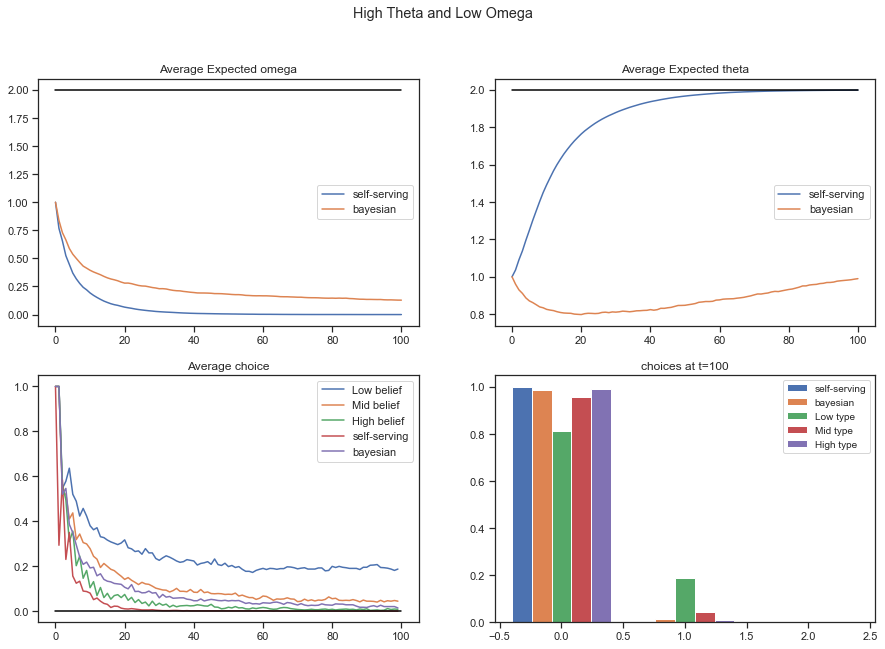

In [134]:
avg_ss = ss_02.groupby('year').mean()
avg_bay = bay_02.groupby('year').mean()
avg_df = df_02.groupby('year').mean()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('High Theta and Low Omega')

fig.set_figheight(10)
fig.set_figwidth(15)

ax1.plot(avg_ss['ew'], label = "self-serving")
ax1.plot(avg_bay['ew'], label = "bayesian")
ax1.plot(2*np.ones(len(avg_ss['ew'])), color = 'black')
ax1.legend()
ax1.set_title('Average Expected omega')

ax2.plot(avg_ss['eth'], label = "self-serving")
ax2.plot(avg_bay['eth'], label = "bayesian")
ax2.plot(2*np.ones(len(avg_ss['eth'])), color = 'black')
ax2.legend()
ax2.set_title('Average Expected theta')

ax3.plot(avg_df['choice_L'], label = "Low belief")
ax3.plot(avg_df['choice_M'], label = "Mid belief")
ax3.plot(avg_df['choice_H'], label = "High belief")
ax3.plot(avg_ss['choice'], label = "self-serving")
ax3.plot(avg_bay['choice'], label = "bayesian")
ax3.plot(0*np.ones(len(avg_ss['choice'])), color = 'black')
ax3.legend()
ax3.set_title('Average choice')

x1 = [ss_02.loc[(slice(None), 99), 'choice'], bay_02.loc[(slice(None), 99), 'choice'], df_02.loc[(slice(None), 99), 'choice_L'], df_02.loc[(slice(None), 99), 'choice_M'], df_02.loc[(slice(None), 99), 'choice_H']]
ax4.hist(x1, [0, 1, 2, 3], density=True, histtype='bar', label=['self-serving', 'bayesian','Low type', 'Mid type', 'High type'], align='left')
ax4.legend(prop={'size': 10})
ax4.set_title('choices at t=100')

Text(0.5, 1.0, 'choices at t=100')

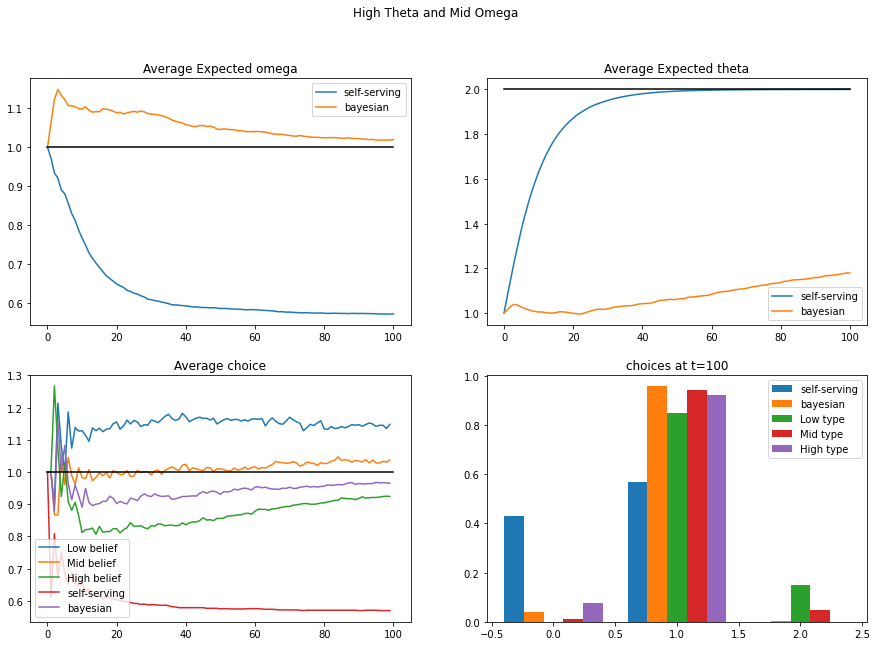

In [68]:
avg_ss = ss_12.groupby('year').mean()
avg_bay = bay_12.groupby('year').mean()
avg_df = df_12.groupby('year').mean()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('High Theta and Mid Omega')

fig.set_figheight(10)
fig.set_figwidth(15)

ax1.plot(avg_ss['ew'], label = "self-serving")
ax1.plot(avg_bay['ew'], label = "bayesian")
ax1.plot(1*np.ones(len(avg_ss['ew'])), color = 'black')
ax1.legend()
ax1.set_title('Average Expected omega')

ax2.plot(avg_ss['eth'], label = "self-serving")
ax2.plot(avg_bay['eth'], label = "bayesian")
ax2.plot(2*np.ones(len(avg_ss['eth'])), color = 'black')
ax2.legend()
ax2.set_title('Average Expected theta')

ax3.plot(avg_df['choice_L'], label = "Low belief")
ax3.plot(avg_df['choice_M'], label = "Mid belief")
ax3.plot(avg_df['choice_H'], label = "High belief")
ax3.plot(avg_ss['choice'], label = "self-serving")
ax3.plot(avg_bay['choice'], label = "bayesian")
ax3.plot(1*np.ones(len(avg_ss['choice'])), color = 'black')
ax3.legend()
ax3.set_title('Average choice')

x1 = [ss_12.loc[(slice(None), 99), 'choice'], bay_12.loc[(slice(None), 99), 'choice'], df_12.loc[(slice(None), 99), 'choice_L'], df_12.loc[(slice(None), 99), 'choice_M'], df_12.loc[(slice(None), 99), 'choice_H']]
ax4.hist(x1, [0, 1, 2, 3], density=True, histtype='bar', label=['self-serving', 'bayesian','Low type', 'Mid type', 'High type'], align='left')
ax4.legend(prop={'size': 10})
ax4.set_title('choices at t=100')

Text(0.5, 1.0, 'choices at t=100')

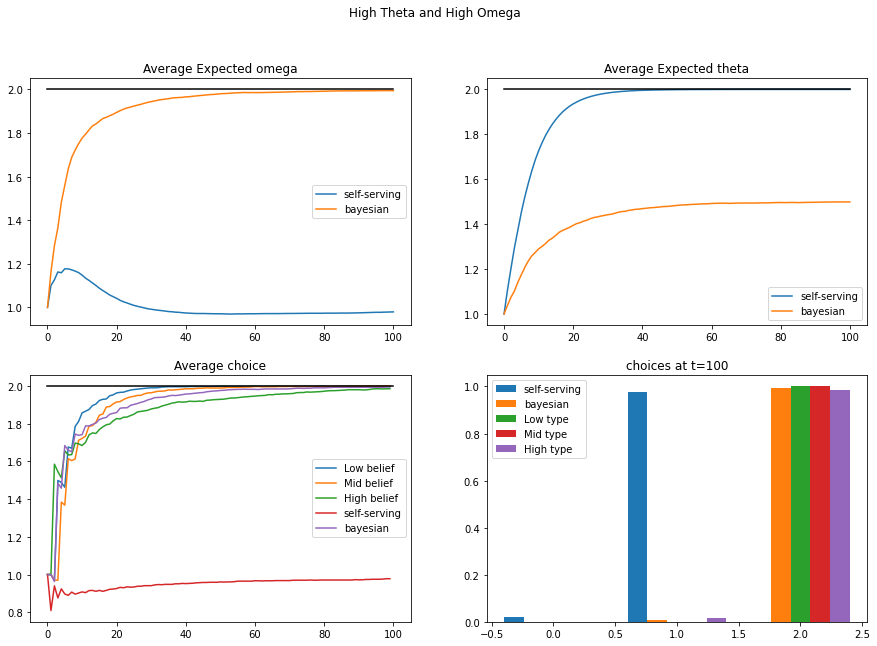

In [69]:
avg_ss = ss_22.groupby('year').mean()
avg_bay = bay_22.groupby('year').mean()
avg_df = df_22.groupby('year').mean()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('High Theta and High Omega')

fig.set_figheight(10)
fig.set_figwidth(15)

ax1.plot(avg_ss['ew'], label = "self-serving")
ax1.plot(avg_bay['ew'], label = "bayesian")
ax1.plot(2*np.ones(len(avg_ss['ew'])), color = 'black')
ax1.legend()
ax1.set_title('Average Expected omega')

ax2.plot(avg_ss['eth'], label = "self-serving")
ax2.plot(avg_bay['eth'], label = "bayesian")
ax2.plot(2*np.ones(len(avg_ss['eth'])), color = 'black')
ax2.legend()
ax2.set_title('Average Expected theta')

ax3.plot(avg_df['choice_L'], label = "Low belief")
ax3.plot(avg_df['choice_M'], label = "Mid belief")
ax3.plot(avg_df['choice_H'], label = "High belief")
ax3.plot(avg_ss['choice'], label = "self-serving")
ax3.plot(avg_bay['choice'], label = "bayesian")
ax3.plot(2*np.ones(len(avg_ss['choice'])), color = 'black')
ax3.legend()
ax3.set_title('Average choice')

x1 = [ss_22.loc[(slice(None), 99), 'choice'], bay_22.loc[(slice(None), 99), 'choice'], df_22.loc[(slice(None), 99), 'choice_L'], df_22.loc[(slice(None), 99), 'choice_M'], df_22.loc[(slice(None), 99), 'choice_H']]
ax4.hist(x1, [0, 1, 2, 3], density=True, histtype='bar', label=['self-serving', 'bayesian','Low type', 'Mid type', 'High type'], align='left')
ax4.legend(prop={'size': 10})
ax4.set_title('choices at t=100')

# Simulate the choices with the likelihood ratio test

In [167]:
df_00.reset_index(inplace=True)
df_10.reset_index(inplace=True)
df_20.reset_index(inplace=True)
df_01.reset_index(inplace=True)
df_11.reset_index(inplace=True)
df_21.reset_index(inplace=True)
df_02.reset_index(inplace=True)
df_12.reset_index(inplace=True)
df_22.reset_index(inplace=True)

ss_00.reset_index(inplace=True)
ss_10.reset_index(inplace=True)
ss_20.reset_index(inplace=True)
ss_01.reset_index(inplace=True)
ss_11.reset_index(inplace=True)
ss_21.reset_index(inplace=True)
ss_02.reset_index(inplace=True)
ss_12.reset_index(inplace=True)
ss_22.reset_index(inplace=True)

bay_00.reset_index(inplace=True)
bay_10.reset_index(inplace=True)
bay_20.reset_index(inplace=True)
bay_01.reset_index(inplace=True)
bay_11.reset_index(inplace=True)
bay_21.reset_index(inplace=True)
bay_02.reset_index(inplace=True)
bay_12.reset_index(inplace=True)
bay_22.reset_index(inplace=True)

<AxesSubplot:xlabel='year', ylabel='Count'>

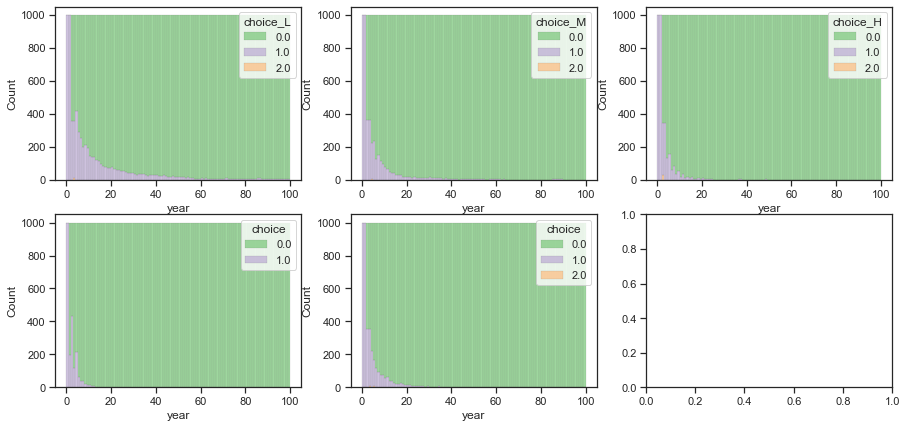

In [184]:
sns.set_theme(style="ticks")
fig, axes = plt.subplots(2, 3, figsize=(15, 7))
sns.despine(f)

sns.histplot(ax=axes[0, 0],
    data=df_00,
    x="year", hue="choice_L",
    multiple="stack",
    palette="Accent",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

sns.histplot(ax=axes[0, 1],
    data=df_00,
    x="year", hue="choice_M",
    multiple="stack",
    palette="Accent",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

sns.histplot(ax=axes[0, 2],
    data=df_00,
    x="year", hue="choice_H",
    multiple="stack",
    palette="Accent",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

sns.histplot(ax=axes[1, 0],
    data=ss_00,
    x="year", hue="choice",
    multiple="stack",
    palette="Accent",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

sns.histplot(ax=axes[1, 1],
    data=bay_00,
    x="year", hue="choice",
    multiple="stack",
    palette="Accent",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

<AxesSubplot:xlabel='year', ylabel='Count'>

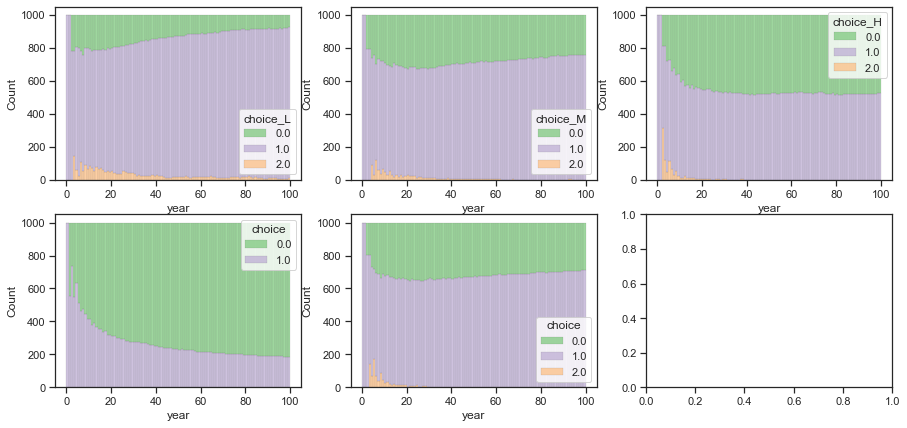

In [183]:
sns.set_theme(style="ticks")
fig, axes = plt.subplots(2, 3, figsize=(15, 7))
sns.despine(f)

sns.histplot(ax=axes[0, 0],
    data=df_10,
    x="year", hue="choice_L",
    multiple="stack",
    palette="Accent",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

sns.histplot(ax=axes[0, 1],
    data=df_10,
    x="year", hue="choice_M",
    multiple="stack",
    palette="Accent",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

sns.histplot(ax=axes[0, 2],
    data=df_10,
    x="year", hue="choice_H",
    multiple="stack",
    palette="Accent",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

sns.histplot(ax=axes[1, 0],
    data=ss_10,
    x="year", hue="choice",
    multiple="stack",
    palette="Accent",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

sns.histplot(ax=axes[1, 1],
    data=bay_10,
    x="year", hue="choice",
    multiple="stack",
    palette="Accent",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

<AxesSubplot:xlabel='year', ylabel='Count'>

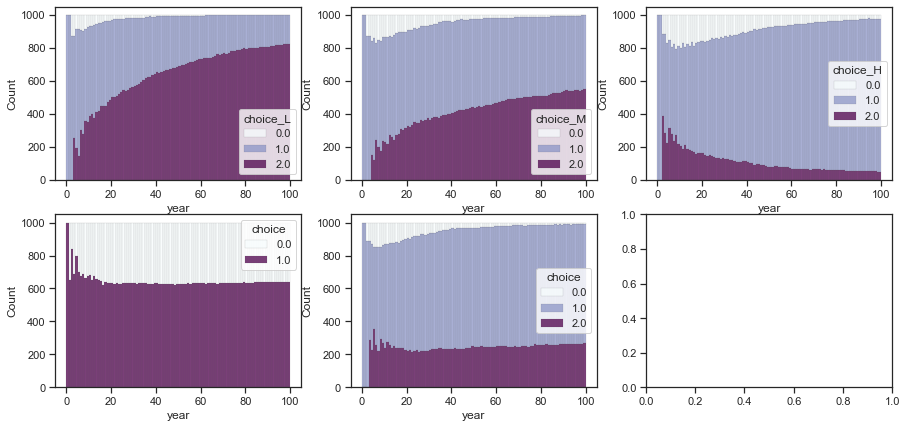

In [198]:
sns.set_theme(style="ticks")
fig, axes = plt.subplots(2, 3, figsize=(15, 7))
sns.despine(f)

sns.histplot(ax=axes[0, 0],
    data=df_20,
    x="year", hue="choice_L",
    multiple="stack",
    palette="BuPu",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

sns.histplot(ax=axes[0, 1],
    data=df_20,
    x="year", hue="choice_M",
    multiple="stack",
    palette="BuPu",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

sns.histplot(ax=axes[0, 2],
    data=df_20,
    x="year", hue="choice_H",
    multiple="stack",
    palette="BuPu",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

sns.histplot(ax=axes[1, 0],
    data=ss_20,
    x="year", hue="choice",
    multiple="stack",
    palette="BuPu",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

sns.histplot(ax=axes[1, 1],
    data=bay_20,
    x="year", hue="choice",
    multiple="stack",
    palette="BuPu",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

<AxesSubplot:xlabel='year', ylabel='Count'>

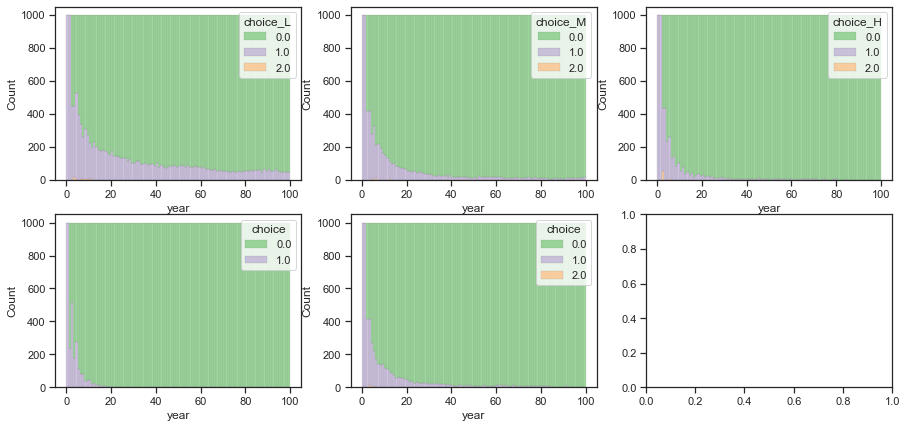

In [175]:
sns.set_theme(style="ticks")
fig, axes = plt.subplots(2, 3, figsize=(15, 7))
sns.despine(f)

sns.histplot(ax=axes[0, 0],
    data=df_01,
    x="year", hue="choice_L",
    multiple="stack",
    palette="Accent",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

sns.histplot(ax=axes[0, 1],
    data=df_01,
    x="year", hue="choice_M",
    multiple="stack",
    palette="Accent",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

sns.histplot(ax=axes[0, 2],
    data=df_01,
    x="year", hue="choice_H",
    multiple="stack",
    palette="Accent",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

sns.histplot(ax=axes[1, 0],
    data=ss_01,
    x="year", hue="choice",
    multiple="stack",
    palette="Accent",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

sns.histplot(ax=axes[1, 1],
    data=bay_01,
    x="year", hue="choice",
    multiple="stack",
    palette="Accent",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

<AxesSubplot:xlabel='year', ylabel='Count'>

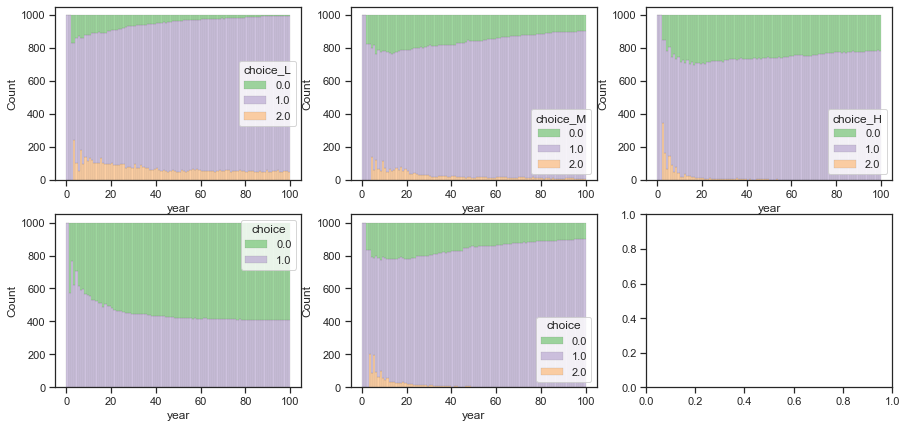

In [176]:
sns.set_theme(style="ticks")
fig, axes = plt.subplots(2, 3, figsize=(15, 7))
sns.despine(f)

sns.histplot(ax=axes[0, 0],
    data=df_11,
    x="year", hue="choice_L",
    multiple="stack",
    palette="Accent",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

sns.histplot(ax=axes[0, 1],
    data=df_11,
    x="year", hue="choice_M",
    multiple="stack",
    palette="Accent",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

sns.histplot(ax=axes[0, 2],
    data=df_11,
    x="year", hue="choice_H",
    multiple="stack",
    palette="Accent",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

sns.histplot(ax=axes[1, 0],
    data=ss_11,
    x="year", hue="choice",
    multiple="stack",
    palette="Accent",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

sns.histplot(ax=axes[1, 1],
    data=bay_11,
    x="year", hue="choice",
    multiple="stack",
    palette="Accent",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

<AxesSubplot:xlabel='year', ylabel='Count'>

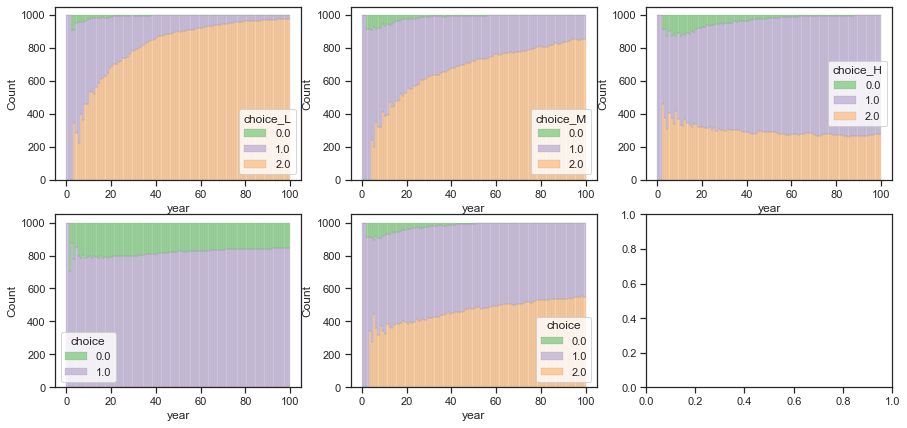

In [177]:
sns.set_theme(style="ticks")
fig, axes = plt.subplots(2, 3, figsize=(15, 7))
sns.despine(f)

sns.histplot(ax=axes[0, 0],
    data=df_21,
    x="year", hue="choice_L",
    multiple="stack",
    palette="Accent",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

sns.histplot(ax=axes[0, 1],
    data=df_21,
    x="year", hue="choice_M",
    multiple="stack",
    palette="Accent",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

sns.histplot(ax=axes[0, 2],
    data=df_21,
    x="year", hue="choice_H",
    multiple="stack",
    palette="Accent",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

sns.histplot(ax=axes[1, 0],
    data=ss_21,
    x="year", hue="choice",
    multiple="stack",
    palette="Accent",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

sns.histplot(ax=axes[1, 1],
    data=bay_21,
    x="year", hue="choice",
    multiple="stack",
    palette="Accent",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

<AxesSubplot:xlabel='year', ylabel='Count'>

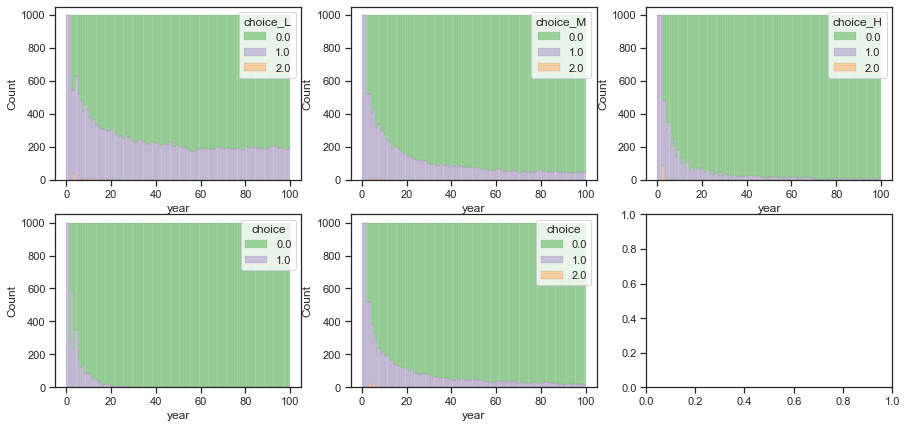

In [178]:
sns.set_theme(style="ticks")
fig, axes = plt.subplots(2, 3, figsize=(15, 7))
sns.despine(f)

sns.histplot(ax=axes[0, 0],
    data=df_02,
    x="year", hue="choice_L",
    multiple="stack",
    palette="Accent",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

sns.histplot(ax=axes[0, 1],
    data=df_02,
    x="year", hue="choice_M",
    multiple="stack",
    palette="Accent",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

sns.histplot(ax=axes[0, 2],
    data=df_02,
    x="year", hue="choice_H",
    multiple="stack",
    palette="Accent",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

sns.histplot(ax=axes[1, 0],
    data=ss_02,
    x="year", hue="choice",
    multiple="stack",
    palette="Accent",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

sns.histplot(ax=axes[1, 1],
    data=bay_02,
    x="year", hue="choice",
    multiple="stack",
    palette="Accent",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

<AxesSubplot:xlabel='year', ylabel='Count'>

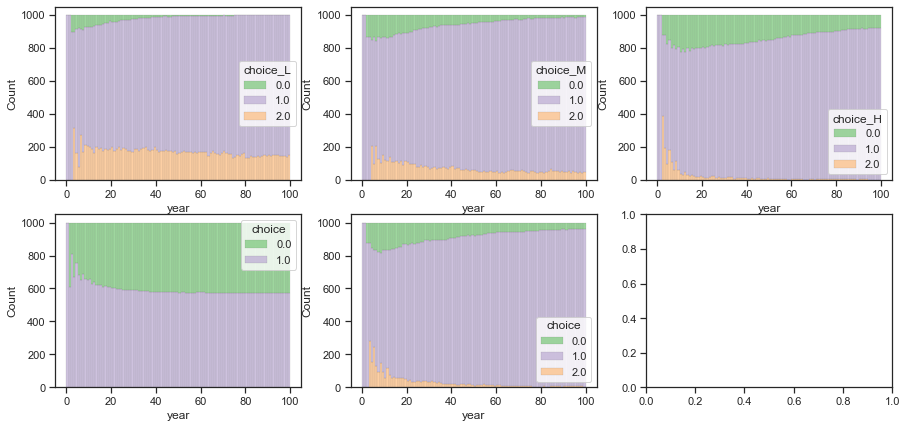

In [181]:
sns.set_theme(style="ticks")
fig, axes = plt.subplots(2, 3, figsize=(15, 7))
sns.despine(f)

sns.histplot(ax=axes[0, 0],
    data=df_12,
    x="year", hue="choice_L",
    multiple="stack",
    palette="Accent",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

sns.histplot(ax=axes[0, 1],
    data=df_12,
    x="year", hue="choice_M",
    multiple="stack",
    palette="Accent",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

sns.histplot(ax=axes[0, 2],
    data=df_12,
    x="year", hue="choice_H",
    multiple="stack",
    palette="Accent",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

sns.histplot(ax=axes[1, 0],
    data=ss_12,
    x="year", hue="choice",
    multiple="stack",
    palette="Accent",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

sns.histplot(ax=axes[1, 1],
    data=bay_12,
    x="year", hue="choice",
    multiple="stack",
    palette="Accent",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

<AxesSubplot:xlabel='year', ylabel='Count'>

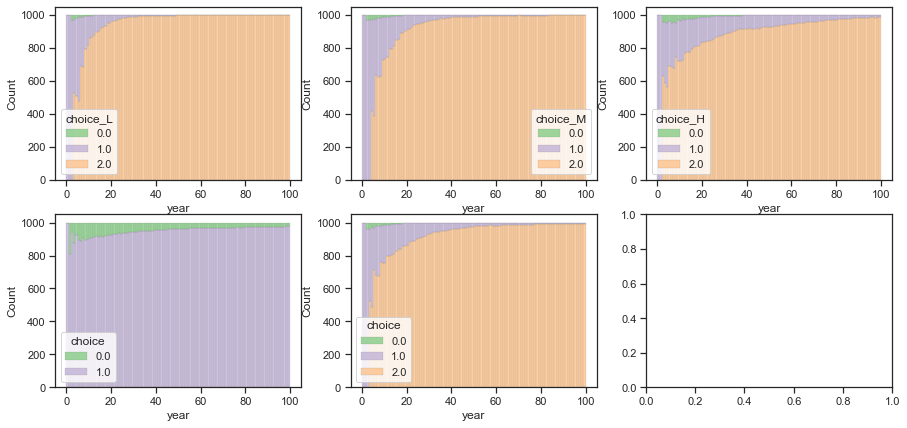

In [182]:
sns.set_theme(style="ticks")
fig, axes = plt.subplots(2, 3, figsize=(15, 7))
sns.despine(f)

sns.histplot(ax=axes[0, 0],
    data=df_22,
    x="year", hue="choice_L",
    multiple="stack",
    palette="Accent",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

sns.histplot(ax=axes[0, 1],
    data=df_22,
    x="year", hue="choice_M",
    multiple="stack",
    palette="Accent",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

sns.histplot(ax=axes[0, 2],
    data=df_22,
    x="year", hue="choice_H",
    multiple="stack",
    palette="Accent",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

sns.histplot(ax=axes[1, 0],
    data=ss_22,
    x="year", hue="choice",
    multiple="stack",
    palette="Accent",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

sns.histplot(ax=axes[1, 1],
    data=bay_22,
    x="year", hue="choice",
    multiple="stack",
    palette="Accent",
    edgecolor=".3",
    linewidth=.1,
    binwidth=1,
    binrange=[0, 100]
)

In [ ]:
df.reset_index(inplace=True)